# Temporal covarance analysis of Pacific Herring populations Prep 1:  MD7000 VCF file

In [1]:
import os
import sys

In [2]:
nb_dir = 'Users/kahotisthammer/programs/cvtkpy'
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import re
from collections import defaultdict, Counter
from itertools import groupby, chain

In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import allel as al

In [5]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.variant_files import VCFFile
from cvtk.gintervals import GenomicIntervals, GenomicInterval
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize, integerize_alternate
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covariances, stack_temporal_covs_by_group, cov_labels
from cvtk.cov import temporal_replicate_cov
from cvtk.bootstrap import block_bootstrap, cov_estimator, bootstrap_ci


/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/gintervals.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/gintervals.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?


In [6]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

## Load in Data

Load in the cleaned and combined metadata created in the Herring scripts. 


In [7]:
md = pd.read_csv('../notebooks/PH_Samples_TempCov.csv')
md

,time,pop,year,abbrv_year,sample,real
0,0,PWS,1991,91,PWS91,True
1,1,PWS,1996,96,PWS96,True
2,2,PWS,2006,6,PWS06,True
3,3,PWS,2017,17,PWS17,True
4,0,SS,1991,91,SS91,False
5,1,SS,1996,96,SS96,True
6,2,SS,2006,6,SS06,True
7,3,SS,2017,17,SS17,True
8,0,TB,1991,91,TB91,True
9,1,TB,1996,96,TB96,True


## Load in VCF file:

In [8]:
var_file = '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD7000_NS0.5_maf05.vcf.gz'

In [9]:
vcf = VCFFile(var_file)

reading file '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD7000_NS0.5_maf05.vcf.gz'...
file '/Users/kahotisthammer/Projects/PacHerring/data/new_vcf/3pop/3pops.MD7000_NS0.5_maf05.vcf.gz' loaded.
total time to load VCF file: 1.3375952164332072 mins.


In [10]:
vcf.geno_mat.shape

(394005, 686, 2)

In [11]:
def parse_sample(x):
    "Parse out the sample metadata from the VCF."
    ind, pop, year = re.match(r'(?P<ind>[^_]+)_(?P<pop>[A-Z]+)(?P<year>[0-9]+)', x).groups()
    sample = pop + year
    return (ind, pop, year, sample)

vcf_md = pd.DataFrame([parse_sample(str(x)) for x in vcf.samples],
                     columns = ['ind', 'pop', 'year', 'sample'])

## Groupo them into Populations 

In [12]:
# now we make this into a nice dictionary of subpops to indices
subpops = defaultdict(list)
for i, sample in enumerate(vcf_md['sample']):
    subpops[sample].append(i)

In [13]:
list(subpops)

['PWS07',
 'PWS17',
 'PWS91',
 'PWS96',
 'SS06',
 'SS17',
 'SS96',
 'TB06',
 'TB17',
 'TB91',
 'TB96']

In [14]:
counts_mat = vcf.count_alleles_subpops(subpops)

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
freq_mat_all = vcf.calc_freqs()

In [16]:
depths_mat_all = vcf.N.astype('f')

Now we use the augmented design to build out the full frequency matrix. If there's a missing timepoint, the matrix of freqs is filled with NANs.

In [17]:
ndiploids = {k:len(subpops[k]) for k in vcf.subpops}
ndiploids['PWS06'] = ndiploids['PWS07']
del ndiploids['PWS07']
ndiploids

{'PWS17': 56,
 'PWS91': 58,
 'PWS96': 72,
 'SS06': 41,
 'SS17': 64,
 'SS96': 78,
 'TB06': 52,
 'TB17': 72,
 'TB91': 74,
 'TB96': 73,
 'PWS06': 46}

In [18]:
subpops_lkup = {sp:i for i, sp in enumerate(vcf.subpops)}
subpops_lkup['PWS06'] = subpops_lkup['PWS07']
del subpops_lkup['PWS07']
subpops_lkup

{'PWS17': 1,
 'PWS91': 2,
 'PWS96': 3,
 'SS06': 4,
 'SS17': 5,
 'SS96': 6,
 'TB06': 7,
 'TB17': 8,
 'TB91': 9,
 'TB96': 10,
 'PWS06': 0}

In [19]:
nloci = freq_mat_all.shape[1]

In [20]:
new_freqs = []
new_depths = []
new_samples = []
new_ndiploids = []

for row in md.itertuples():
    sample = row.sample
    if not row.real:
        print(sample + " is a NA sample")
        freqs = np.empty((nloci))
        freqs[:] = np.nan
        depths = np.empty((nloci))
        depths[:] = np.nan
        ndips = 0   
    else:
        freqs = freq_mat_all[subpops_lkup[sample], :]
        depths = depths_mat_all[subpops_lkup[sample], :]        
        ndips = ndiploids[sample]
    new_freqs.append(freqs)
    new_depths.append(depths)
    new_samples.append((row.pop, row.year))
    new_ndiploids.append(ndips)
    
full_depths_mat = np.row_stack(new_depths)
full_depths_mat.shape

SS91 is a NA sample


(12, 394005)

In [21]:
full_freq_mat = np.row_stack(new_freqs)
full_freq_mat.shape

(12, 394005)

In [22]:
new_samples

[('PWS', 1991),
 ('PWS', 1996),
 ('PWS', 2006),
 ('PWS', 2017),
 ('SS', 1991),
 ('SS', 1996),
 ('SS', 2006),
 ('SS', 2017),
 ('TB', 1991),
 ('TB', 1996),
 ('TB', 2006),
 ('TB', 2017)]

## Building the Temporal Freqs Object

First, we need to build the tiled `TemporalFreqs` object. We load in the sequence lengths.

In [23]:
sl_d = pd.read_csv('../data/chr_sizes.bed', delimiter='\t', names=['chrom', 'start', 'end'], header=None)

seqlens = dict(zip(sl_d['chrom'].values, sl_d['end'].values))

In [24]:
seqlens

{'chr1': 33084258,
 'chr2': 33010319,
 'chr3': 32527562,
 'chr4': 32267647,
 'chr5': 31586861,
 'chr6': 31461554,
 'chr7': 30990621,
 'chr8': 30729556,
 'chr9': 30477381,
 'chr10': 30227731,
 'chr11': 30096327,
 'chr12': 30022480,
 'chr13': 29845739,
 'chr14': 29332771,
 'chr15': 28713521,
 'chr16': 27773822,
 'chr17': 27568510,
 'chr18': 27247294,
 'chr19': 27130643,
 'chr20': 26694162,
 'chr21': 26465981,
 'chr22': 25664052,
 'chr23': 25292897,
 'chr24': 20091098,
 'chr25': 14924191,
 'chr26': 12443209}

In [25]:
#100,000 interval 
tile_width = int(1e5)
tiles = GenomicIntervals.from_tiles(seqlens, width=tile_width)

In [56]:
#75,000 interval 
tile_width = 75000
tiles = GenomicIntervals.from_tiles(seqlens, width=tile_width)

In [26]:
#50,000 interval 
tile_width = 50000
tiles = GenomicIntervals.from_tiles(seqlens, width=tile_width)

In [26]:
tiles

GenomicIntervals — 26 unique seqids, 7242 features
         GenomicInterval
0       chr1:[0, 100000)
1  chr1:[100000, 200000)
2  chr1:[200000, 300000)
3  chr1:[300000, 400000)
4  chr1:[400000, 500000)
[ 7237 more GenomicIntervals ]

In [28]:
#Check the matrix sizes are the same
assert(full_freq_mat.shape == full_depths_mat.shape)

What's average coverage?

In [30]:
diploid_mean = np.mean(list(ndiploids.values())) # TODO Change, use full vector
diploid_mean

62.36363636363637

In [27]:
gi = vcf.build_gintervals()

In [38]:
gi

GenomicIntervals — 26 unique seqids, 394005 features
       GenomicInterval
0  chr1:[24227, 24228)
1  chr1:[24456, 24457)
2  chr1:[24457, 24458)
3  chr1:[24484, 24485)
4  chr1:[28680, 28681)
[ 394000 more GenomicIntervals ]

In [28]:
list(zip(new_samples, new_ndiploids))
#zip() Joins two tuples together:

[(('PWS', 1991), 58),
 (('PWS', 1996), 72),
 (('PWS', 2006), 46),
 (('PWS', 2017), 56),
 (('SS', 1991), 0),
 (('SS', 1996), 78),
 (('SS', 2006), 41),
 (('SS', 2017), 64),
 (('TB', 1991), 74),
 (('TB', 1996), 73),
 (('TB', 2006), 52),
 (('TB', 2017), 72)]

In [40]:
new_ndiploids

[58, 72, 46, 56, 0, 78, 41, 64, 74, 73, 52, 72]

Run 'TiledTemporalFreqs' from cvtk with 100,000 tile size

In [55]:
full_depths_mat.shape

(12, 394005)

In [54]:
full_depths_mat

array([[ 74.,  80.,  80., ...,  66.,  62.,  60.],
       [106.,  86.,  82., ...,  94.,  88.,  82.],
       [ 66.,  60.,  60., ...,  60.,  68.,  56.],
       ...,
       [106., 106., 108., ...,  84.,  96.,  90.],
       [102.,  74.,  72., ...,  64.,  74.,  62.],
       [116., 116., 114., ...,  94.,  94.,  90.]])

In [29]:
d = TiledTemporalFreqs(tiles, freqs=full_freq_mat, depths=full_depths_mat, diploids=new_ndiploids, gintervals=gi, samples=new_samples)

In [32]:
# no diploid correction
d1 = TiledTemporalFreqs(tiles, freqs=full_freq_mat, depths=full_depths_mat, gintervals=gi, samples=new_samples)

In [33]:
d1.calc_cov(use_masked=True)

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:375: RuntimeWarning: Mean of empty slice


array([[ 1.47814282e-02, -5.80245997e-03, -1.11655205e-03,
                    nan,             nan,             nan,
        -1.09498094e-03, -7.93105619e-05, -3.42209689e-04],
       [-5.80245997e-03,  1.69328198e-02, -1.13857963e-02,
                    nan,  1.34523310e-04, -5.20667454e-05,
         5.36595776e-06,  3.95839109e-05, -2.28053613e-04],
       [-1.11655205e-03, -1.13857963e-02,  1.99001684e-02,
                    nan,  1.26634085e-03, -1.07623113e-03,
         8.96924180e-04,  3.09461139e-04,  4.91119033e-04],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [            nan,  1.34523310e-04,  1.26634085e-03,
                    nan,  1.96405698e-02, -1.37302786e-02,
                    nan,  2.12813000e-04,  8.94944150e-05],
       [            nan, -5.20667454e-05, -1.07623113e-03,
                    nan, -1.37302786e-02,  2.207488

In [35]:
# create labels for plots, for temporal covariances
stacked_temp_labs = stack_temporal_covariances(cov_labels(d.R, d.T, d.samples, lab_var=True), d.R, d.T)

In [36]:
#Save the results matrix
cov1=d1.calc_cov(use_masked=True)
pws_cov=pd.DataFrame(stack_temporal_covariances(cov1, d.R, d.T).T[0])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_cov, pws_labs]
pws = pd.concat(frames)
pws.to_csv("MD7000_no_diploid_biasCorrection_temp_cov_matrix_PWS.csv")

SS_cov=pd.DataFrame(stack_temporal_covariances(cov1, d.R, d.T).T[1])
SS_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [SS_cov, SS_labs]
SS = pd.concat(frames)
SS.to_csv("MD7000_no_diploid_biasCorrection_temp_cov_matrix_SS.csv")

tb_cov=pd.DataFrame(stack_temporal_covariances(cov1, d.R, d.T).T[2])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_cov, tb_labs]
tb = pd.concat(frames)
tb.to_csv("MD7000_no_diploid_biasCorrection_temp_cov_matrix_TB.csv")

In [57]:
np.diag(d1.calc_cov(use_masked=True))

array([0.01478134, 0.01693279, 0.01990011,        nan, 0.01964086,
       0.02207518, 0.01473637, 0.01750179, 0.01792746])

In [30]:
d2 = TiledTemporalFreqs(tiles, freqs=full_freq_mat, diploids=new_ndiploids, gintervals=gi, samples=new_samples)

In [59]:
np.diag(d2.calc_cov(use_masked=True))

array([0.02213922, 0.02451324, 0.02858977,        nan, 0.02859104,
       0.03279112, 0.02093642, 0.02594285, 0.02647337])

In [38]:
cov2=d2.calc_cov(use_masked=True)
pws_cov=pd.DataFrame(stack_temporal_covariances(cov2, d.R, d.T).T[0])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_cov, pws_labs]
pws = pd.concat(frames)
pws.to_csv("MD7000_no_depth_biasCorrection_temp_cov_matrix_PWS.csv")

SS_cov=pd.DataFrame(stack_temporal_covariances(cov2, d.R, d.T).T[1])
SS_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [SS_cov, SS_labs]
SS = pd.concat(frames)
SS.to_csv("MD7000_no_depth_biasCorrection_temp_cov_matrix_SS.csv")

tb_cov=pd.DataFrame(stack_temporal_covariances(cov2, d.R, d.T).T[2])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_cov, tb_labs]
tb = pd.concat(frames)
tb.to_csv("MD7000_no_depth_biasCorrection_temp_cov_matrix_TB.csv")

In [39]:
d3=TiledTemporalFreqs(tiles, freqs=full_freq_mat, gintervals=gi, samples=new_samples)

In [41]:
cov3=d3.calc_cov(use_masked=True)
pws_cov=pd.DataFrame(stack_temporal_covariances(cov3, d.R, d.T).T[0])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_cov, pws_labs]
pws = pd.concat(frames)
pws.to_csv("MD7000_no_both_biasCorrection_temp_cov_matrix_PWS.csv")

SS_cov=pd.DataFrame(stack_temporal_covariances(cov3, d.R, d.T).T[1])
SS_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [SS_cov, SS_labs]
SS = pd.concat(frames)
SS.to_csv("MD7000_no_both_biasCorrection_temp_cov_matrix_SS.csv")

tb_cov=pd.DataFrame(stack_temporal_covariances(cov3, d.R, d.T).T[2])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_cov, tb_labs]
tb = pd.concat(frames)
tb.to_csv("MD7000_no_both_biasCorrection_temp_cov_matrix_TB.csv")

In [63]:
d.freqs.shape

(3, 4, 394005)

In [38]:
#pd.DataFrame(d.freqs[0,:,:].transpose()).to_csv("MD7000_Temp_freq_PSW_100kwindow.csv", index=False)

In [39]:
#pd.DataFrame(d.freqs[1,:,:].transpose()).to_csv("MD7000_Temp_freq_SS_100kwindow.csv", index=False)

In [40]:
#pd.DataFrame(d.freqs[2,:,:].transpose()).to_csv("MD7000_Temp_freq_TB_100kwindow.csv", index=False)

(array([330482.,      0.,  43725., 391537., 733112., 961849., 808095.,
        495480., 172451.,  29053.]),
 array([  0. ,  15.6,  31.2,  46.8,  62.4,  78. ,  93.6, 109.2, 124.8,
        140.4, 156. ]),
 <BarContainer object of 10 artists>)

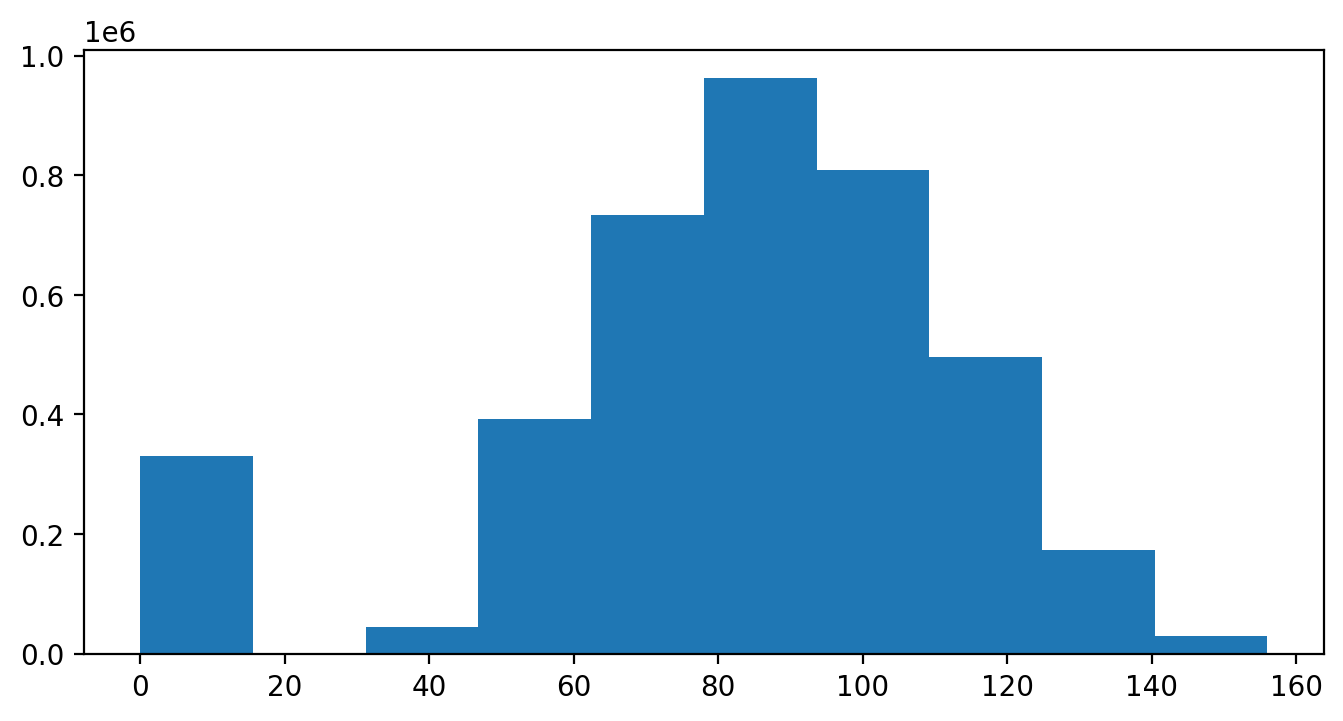

In [43]:
plt.hist(d.depths.flatten())

What's the proportion of missing data?

In [38]:
np.isnan(full_freq_mat).sum() / np.prod(full_freq_mat.shape)

0.08333333333333333

Calculate covariacne using calc_cov form cvtk.py:

#Required parameters are:
calc_cov(self, keep_seqids=None, bias_correction=True,
                 standardize=True, use_masked=False, product_only=False)
                 
#Which call the following function
temporal_replicate_cov(freqs, depths=None, diploids=None,
                           bias_correction=True, standardize=True, deltas=None,
                           use_masked=False, share_first=False,
                           product_only=False,
                           return_ratio_parts=False, warn=False):
             

In [64]:
gw_covs = d.calc_cov(use_masked=True) #ma.masked_invalid in numpy identifies NaN or Inf

In [65]:
np.diag(d.calc_cov(use_masked=False))

array([-1.49654710e-03, -2.06820544e-03,  6.79012885e-05,             nan,
        1.25242031e-03,  5.78532629e-04,  1.27834462e-03,  6.83162739e-04,
        7.66141772e-04])

In [44]:
gw_covs
#np.savetxt("MD7000_gw_covs_100k.csv", gw_covs, delimiter=",")

array([[-1.49636143e-03,  1.55495367e-03, -1.10694712e-03,
                    nan,             nan,             nan,
        -1.08656451e-03, -7.86768422e-05, -3.39472497e-04],
       [ 1.55495367e-03, -2.06811092e-03,  4.96259070e-04,
                    nan,  1.33547053e-04, -5.17464520e-05,
         5.37971030e-06,  3.92514111e-05, -2.26357670e-04],
       [-1.10694712e-03,  4.96259070e-04,  6.84723407e-05,
                    nan,  1.25793014e-03, -1.06393288e-03,
         8.90006478e-04,  3.07306485e-04,  4.86010407e-04],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [            nan,  1.33547053e-04,  1.25793014e-03,
                    nan,  1.25286404e-03, -1.90921513e-03,
                    nan,  2.11337799e-04,  8.87547491e-05],
       [            nan, -5.17464520e-05, -1.06393288e-03,
                    nan, -1.90921513e-03,  5.787401

In [45]:
gw_covs_nocorrect = d.calc_cov(bias_correction=False,use_masked=True) #ma.masked_invalid in numpy identifies NaN or Inf

In [52]:
np.diag(gw_covs_nocorrect)

array([0.03746038, 0.0424289 , 0.04694272,        nan, 0.0457785 ,
       0.05243646, 0.03370846, 0.04174453, 0.04245686])

In [46]:
stack_temporal_covariances(gw_covs, d.R, d.T).T[0]

array([[-1.49636143e-03,  1.55495367e-03, -1.10694712e-03],
       [ 1.55495367e-03, -2.06811092e-03,  4.96259070e-04],
       [-1.10694712e-03,  4.96259070e-04,  6.84723407e-05]])

In [47]:
# create labels for plots, for temporal covariances
stacked_temp_labs = stack_temporal_covariances(cov_labels(d.R, d.T, d.samples, lab_var=True), d.R, d.T)
stacked_temp_labs.T

array([[['var(PWS: 1996-1991)', 'cov(PWS: 1996-1991, PWS: 2006-1996)',
         'cov(PWS: 1996-1991, PWS: 2017-2006)'],
        ['cov(PWS: 2006-1996, PWS: 1996-1991)', 'var(PWS: 2006-1996)',
         'cov(PWS: 2006-1996, PWS: 2017-2006)'],
        ['cov(PWS: 2017-2006, PWS: 1996-1991)',
         'cov(PWS: 2017-2006, PWS: 2006-1996)', 'var(PWS: 2017-2006)']],

       [['var(SS: 1996-1991)', 'cov(SS: 1996-1991, SS: 2006-1996)',
         'cov(SS: 1996-1991, SS: 2017-2006)'],
        ['cov(SS: 2006-1996, SS: 1996-1991)', 'var(SS: 2006-1996)',
         'cov(SS: 2006-1996, SS: 2017-2006)'],
        ['cov(SS: 2017-2006, SS: 1996-1991)',
         'cov(SS: 2017-2006, SS: 2006-1996)', 'var(SS: 2017-2006)']],

       [['var(TB: 1996-1991)', 'cov(TB: 1996-1991, TB: 2006-1996)',
         'cov(TB: 1996-1991, TB: 2017-2006)'],
        ['cov(TB: 2006-1996, TB: 1996-1991)', 'var(TB: 2006-1996)',
         'cov(TB: 2006-1996, TB: 2017-2006)'],
        ['cov(TB: 2017-2006, TB: 1996-1991)',
         'cov(T

In [39]:
#Save each matrix
pws_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[0])
pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
frames = [pws_cov, pws_labs]
pws = pd.concat(frames)
#pws.to_csv("3Pops_maf05_temp_cov_matrix_PWS_100k.csv")
pws.to_csv("3Pops_maf05_temp_cov_matrix_PWS_50k.csv")

In [40]:
#Save each matrix
SS_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[1])
SS_labs=pd.DataFrame(stacked_temp_labs.T[1])
frames = [SS_cov, SS_labs]
SS = pd.concat(frames)
#SS.to_csv("MD7000_maf05_temp_cov_matrix_SS_100k.csv")
SS.to_csv("MD7000_maf05_temp_cov_matrix_SS_50k.csv")

In [41]:
#Save each matrix
tb_cov=pd.DataFrame(stack_temporal_covariances(gw_covs, d.R, d.T).T[2])
tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
frames = [tb_cov, tb_labs]
tb = pd.concat(frames)
#tb.to_csv("MD7000_maf05_temp_cov_matrix_TB_100k.csv")
tb.to_csv("MD7000_maf05_temp_cov_matrix_TB_50k.csv")

### Bootstrapping Temporal Covs

In [35]:
# Conduct manually
#gw_covs_cis = d.bootstrap_cov(B=5000, progress_bar=True, average_replicates=False)

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:348: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


bootstraps:   0%|          | 0/5000 [00:00<?, ?it/s]

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [83]:
#pws_ci_lower=pd.DataFrame(gw_covs_cis[0,0:3,0:3])
#pws_ci_upper=pd.DataFrame(gw_covs_cis[2,0:3,0:3])
#pws_labs=pd.DataFrame(stacked_temp_labs.T[0])
#frames = [pws_ci_lower, pws_ci_upper, pws_labs]
#pws = pd.concat(frames)
#pws.to_csv("MD7000_maf05_PWS_Cov_CIs_bootstrap5000_1Mwindow.csv")

,0,1,2
0,-0.003086,0.001805,-0.001176
1,0.001805,-0.003809,0.000925
2,-0.001176,0.000925,-0.001719
0,-0.00233,0.002305,-0.000728
1,0.002305,-0.002949,0.001563
2,-0.000728,0.001563,-0.000816
0,var(PWS: 1996-1991),"cov(PWS: 1996-1991, PWS: 2006-1996)","cov(PWS: 1996-1991, PWS: 2017-2006)"
1,"cov(PWS: 2006-1996, PWS: 1996-1991)",var(PWS: 2006-1996),"cov(PWS: 2006-1996, PWS: 2017-2006)"
2,"cov(PWS: 2017-2006, PWS: 1996-1991)","cov(PWS: 2017-2006, PWS: 2006-1996)",var(PWS: 2017-2006)


In [85]:
#ss_ci_lower=pd.DataFrame(gw_covs_cis[0,3:6,3:6])
#ss_ci_upper=pd.DataFrame(gw_covs_cis[2,3:6,3:6])
#ss_labs=pd.DataFrame(stacked_temp_labs.T[1])
#frames = [ss_ci_lower, ss_ci_upper, ss_labs]
#ss = pd.concat(frames)
#ss.to_csv("MD7000_maf05_SS_Cov_CIs_bootstrap5000_1Mwindow.csv")

In [68]:
ss

,0,1,2
0,NaN,NaN,NaN
1,NaN,0.000187,-0.001746
2,NaN,-0.001746,-0.000437
0,NaN,NaN,NaN
1,NaN,0.000917,-0.001153
2,NaN,-0.001153,0.000409
0,var(SS: 1996-1991),"cov(SS: 1996-1991, SS: 2006-1996)","cov(SS: 1996-1991, SS: 2017-2006)"
1,"cov(SS: 2006-1996, SS: 1996-1991)",var(SS: 2006-1996),"cov(SS: 2006-1996, SS: 2017-2006)"
2,"cov(SS: 2017-2006, SS: 1996-1991)","cov(SS: 2017-2006, SS: 2006-1996)",var(SS: 2017-2006)


In [86]:
#tb_ci_upper=pd.DataFrame(gw_covs_cis[0,6:10,6:10])
#tb_ci_lower=pd.DataFrame(gw_covs_cis[2,6:10,6:10])
#tb_labs=pd.DataFrame(stacked_temp_labs.T[2])
#frames = [tb_ci_upper, tb_ci_lower, tb_labs]
#tb = pd.concat(frames)
#
#tb.to_csv("MD7000_maf05_TB_Cov_CIs_bootstrap5000_1Mwindow.csv")

## Calculate G

In [66]:
g_averep = d.calc_G() 

[0.0038932         nan 0.00283601]
[0.00516541        nan 0.00340319]
[0.00440381        nan 0.00290538]


In [49]:
g_averep

array([[-0.        ,         nan,  0.        ],
       [-5.97017563,         nan,  0.28190615],
       [-1.17383494,         nan, -0.16419367]])

In [67]:
g_averep

array([[-0.        ,         nan,  0.        ],
       [-5.96156579,         nan,  0.28189294],
       [-1.17450929,         nan, -0.16420261]])

In [61]:
g_cis = d.bootstrap_G(B=5000, progress_bar=True)

[0.00357662        nan 0.00298888]
[0.00475661        nan 0.00358056]
[0.00405893        nan 0.00306148]
[0.00344612        nan 0.00208503]
[0.00402015        nan 0.00213418]
[0.00528638        nan 0.00146401]
[0.00317204        nan 0.00279783]
[0.00306504        nan 0.00071027]
[0.00345162        nan 0.00351436]
[0.00354569        nan 0.00128957]
[0.00384974        nan 0.00398337]
[0.0023837         nan 0.00125377]
[0.00363739        nan 0.00240904]
[0.00570495        nan 0.0040883 ]
[0.00430023        nan 0.00465259]
[0.00348343        nan 0.00296003]
[0.00452388        nan 0.00385611]
[0.00281536        nan 0.00260633]
[0.00353302        nan 0.00398446]
[0.00319268        nan 0.0020758 ]
[0.0016569       nan 0.0043961]
[0.00452722        nan 0.00440148]
[0.00383895        nan 0.00285884]
[0.00487506        nan 0.00477576]
[0.00199968        nan 0.00276049]
[0.00344307        nan 0.00122641]
[0.00126057        nan 0.00185297]
[0.00324816        nan 0.00334613]
[0.00230979        nan 

[0.00702626        nan 0.00032518]
[0.00424108        nan 0.00138316]
[0.00331503        nan 0.00204043]
[0.00221709        nan 0.0030002 ]
[0.00341359        nan 0.00254879]
[0.00365036        nan 0.00245207]
[0.0045403         nan 0.00082656]
[0.00346033        nan 0.00338559]
[0.00230907        nan 0.00142491]
[0.00399584        nan 0.00284816]
[0.0025272         nan 0.00300262]
[0.00303757        nan 0.00101513]
[2.19697902e-03            nan 6.47077421e-05]
[0.00251131        nan 0.0016397 ]
[0.00321353        nan 0.00278638]
[0.00159378        nan 0.00315613]
[0.00387044        nan 0.00104022]
[0.00268965        nan 0.00498318]
[0.0037834         nan 0.00295842]
[0.0026346         nan 0.00328126]
[0.00179932        nan 0.0024284 ]
[0.00272663        nan 0.00723025]
[0.0024534         nan 0.00189493]
[0.00451186        nan 0.00336785]
[0.0041053         nan 0.00204543]
[0.00339885        nan 0.00228143]
[0.00269364        nan 0.00081281]
[0.00328359        nan 0.00106899]
[0.00323

[0.00284654        nan 0.00099004]
[0.00340038        nan 0.00060244]
[0.00153267        nan 0.00141707]
[0.00261517        nan 0.00108865]
[0.00796858        nan 0.00118321]
[0.00204413        nan 0.00160401]
[0.00234538        nan 0.00186519]
[0.00253006        nan 0.0014422 ]
[0.00382175        nan 0.00127908]
[0.00289245        nan 0.00258729]
[0.00371697        nan 0.00049379]
[0.00125278        nan 0.00058101]
[0.00326136        nan 0.00231382]
[0.00330968        nan 0.00123432]
[0.00253714        nan 0.00124721]
[0.00338868        nan 0.00143638]
[0.00208075        nan 0.00087088]
[0.0047059         nan 0.00217633]
[0.00247994        nan 0.00492199]
[0.00178066        nan 0.00245379]
[0.00370547        nan 0.00081218]
[0.00243727        nan 0.00449192]
[0.00140638        nan 0.00433559]
[0.00438516        nan 0.00224794]
[0.00420937        nan 0.00291498]
[0.00296245        nan 0.00335358]
[0.00243167        nan 0.0014797 ]
[0.00325771        nan 0.0066364 ]
[0.00281916        n

[0.00293686        nan 0.00685974]
[0.00450512        nan 0.00183702]
[0.00388472        nan 0.00110067]
[0.00385282        nan 0.00186044]
[0.005239          nan 0.00162377]
[0.00263684        nan 0.00109947]
[0.00367486        nan 0.00243856]
[0.00335024        nan 0.00033161]
[0.00477497        nan 0.00276382]
[0.00281028        nan 0.00168569]
[0.00270536        nan 0.00166303]
[0.00207268        nan 0.00488272]
[0.00229313        nan 0.00419266]
[0.00374679        nan 0.00329138]
[0.00449636        nan 0.00403393]
[0.00244542        nan 0.00544691]
[0.00276838        nan 0.00223162]
[0.00326471        nan 0.00200325]
[0.00213372        nan 0.0024348 ]
[0.0010922         nan 0.00256243]
[0.0052172       nan 0.0021589]
[0.00211578        nan 0.0036565 ]
[0.00254148        nan 0.00389036]
[0.0021106         nan 0.00290797]
[0.00418799        nan 0.00126657]
[0.00303725        nan 0.00174961]
[0.00345563        nan 0.00179374]
[0.00667118        nan 0.00122288]
[0.00637021        nan 

[0.00241598        nan 0.00174892]
[0.00426042        nan 0.00166355]
[0.00339819        nan 0.00252783]
[0.00155464        nan 0.00452938]
[0.00229314        nan 0.00175421]
[0.00426267        nan 0.00219257]
[0.00204844        nan 0.00046475]
[nan nan nan]
[0.00157002        nan 0.00375584]
[0.00315902        nan 0.00335302]
[0.00175365        nan 0.00260995]
[0.00219565        nan 0.00286999]
[0.00200827        nan 0.00255915]
[0.0024408       nan 0.0054372]
[0.00236369        nan 0.00175294]
[0.00263313        nan 0.00467708]
[0.00277113        nan 0.00257045]
[0.00289549        nan 0.00235069]
[0.00423304        nan 0.00224852]
[0.00080347        nan 0.00244983]
[0.00767504        nan 0.00161069]
[0.0043416         nan 0.00196403]
[0.00270898        nan 0.00287951]
[0.00285617        nan 0.00235358]
[0.0029162         nan 0.00376644]
[0.00310709        nan 0.00699209]
[0.00288691        nan 0.00313103]
[0.00240937        nan 0.0014132 ]
[0.00227263        nan 0.00215647]
[0.005050

[0.001969          nan 0.00217339]
[0.0039222         nan 0.00182026]
[0.00346562        nan 0.00136514]
[0.00318693        nan 0.00173417]
[0.00326         nan 0.0022959]
[0.00791192        nan 0.00030103]
[0.00668215        nan 0.00114256]
[0.00508677        nan 0.00359477]
[0.00028272        nan 0.00845186]
[0.00263133        nan 0.00103344]
[0.00276761        nan 0.0036605 ]
[0.00271971        nan 0.00300984]
[0.00186222        nan 0.00251368]
[0.0024502         nan 0.00106154]
[0.00285275        nan 0.00258562]
[0.00112964        nan 0.00067993]
[0.00216237        nan 0.00186568]
[0.00410573        nan 0.00113728]
[0.00211252        nan 0.00438098]
[0.00702857        nan 0.00262972]
[0.00522425        nan 0.0006012 ]
[0.0034191         nan 0.00106517]
[0.00281114        nan 0.00100891]
[0.00196443        nan 0.00149242]
[0.00432139        nan 0.00165308]
[0.00478909        nan 0.00214754]
[0.00341989        nan 0.00141814]
[0.00368177        nan 0.00074146]
[0.00517241        nan 

[0.00188499        nan 0.00186504]
[0.00303876        nan 0.00183082]
[0.00300305        nan 0.00250532]
[0.00209517        nan 0.0017201 ]
[0.0033222         nan 0.00253037]
[0.00275686        nan 0.00291751]
[0.00345587        nan 0.00218539]
[0.00235391        nan 0.00170374]
[0.0058491         nan 0.00271746]
[0.00174946        nan 0.00093602]
[0.00280753        nan 0.00171553]
[0.00236722        nan 0.00512216]
[0.00370738        nan 0.00479895]
[0.00277812        nan 0.00278329]
[0.00211409        nan 0.00257555]
[0.00245078        nan 0.00378124]
[0.00281641        nan 0.00541675]
[0.00125725        nan 0.00505975]
[0.00391243        nan 0.00127114]
[0.00293045        nan 0.00550882]
[0.00348896        nan 0.00202384]
[0.0018139         nan 0.00446349]
[0.00180693        nan 0.00337229]
[0.00335937        nan 0.0017607 ]
[0.00255433        nan 0.00169307]
[0.00242634        nan 0.00128897]
[0.00312183        nan 0.00237102]
[0.00257255        nan 0.00176477]
[0.00182842        n

[0.00308973        nan 0.00074337]
[0.00101305        nan 0.00593878]
[0.00312675        nan 0.00242687]
[0.00440178        nan 0.00507579]
[0.00226287        nan 0.00086977]
[0.00037822        nan 0.00636027]
[0.00706735        nan 0.00563221]
[0.00334836        nan 0.00062124]
[0.00782955        nan 0.00482841]
[0.00191529        nan 0.00162071]
[0.00336229        nan 0.00211061]
[0.00297804        nan 0.00061472]
[0.002846          nan 0.00053188]
[0.0032333         nan 0.00257463]
[0.00290132        nan 0.00264101]
[0.00215511        nan 0.00508195]
[0.0080863         nan 0.00398398]
[0.0031923         nan 0.00261486]
[0.00206998        nan 0.00306836]
[0.00213958        nan 0.00509326]
[0.00330458        nan 0.0040159 ]
[0.00312777        nan 0.00214796]
[0.00431608        nan 0.00244158]
[0.00224679        nan 0.00362565]
[0.00253195        nan 0.00248073]
[0.00218355        nan 0.00299412]
[0.00233075        nan 0.0026691 ]
[0.00257938        nan 0.00173833]
[0.00345528        n

[0.00355506        nan 0.00256834]
[0.00444836        nan 0.00227743]
[0.00265214        nan 0.00085038]
[0.00186478        nan 0.00178057]
[0.00404965        nan 0.0016706 ]
[0.00454995        nan 0.00262844]
[0.00327031        nan 0.00158822]
[0.00110037        nan 0.0023417 ]
[0.00240722        nan 0.00284822]
[0.00412215        nan 0.00095748]
[0.00298972        nan 0.00176367]
[0.00291191        nan 0.00262656]
[0.00270464        nan 0.00417866]
[0.00309655        nan 0.00413387]
[0.00306984        nan 0.0027277 ]
[0.00520238        nan 0.00042602]
[0.00224808        nan 0.0011135 ]
[0.00297937        nan 0.00225974]
[0.00441208        nan 0.00268993]
[0.00603928        nan 0.00297928]
[0.0023965         nan 0.00314102]
[0.00258982        nan 0.00249346]
[0.00426683        nan 0.00156641]
[0.00452132        nan 0.0012375 ]
[0.0026099         nan 0.00278424]
[0.00386172        nan 0.00578444]
[0.00337933        nan 0.00414053]
[0.00495658        nan 0.00292872]
[0.00319181        n

[0.00049806        nan 0.00123914]
[0.00294003        nan 0.00351699]
[0.00275438        nan 0.00589235]
[0.00415545        nan 0.00160356]
[0.0044729       nan 0.0043042]
[0.00283947        nan 0.00135719]
[0.00478136        nan 0.00065482]
[0.00093434        nan 0.00064083]
[0.00600179        nan 0.001931  ]
[0.00541206        nan 0.00273512]
[0.00339797        nan 0.00234004]
[0.00264829        nan 0.00179355]
[0.00282904        nan 0.00185004]
[0.00503368        nan 0.00206505]
[0.00404845        nan 0.00145194]
[0.00000000e+00            nan 1.50182622e-06]
[0.00228442        nan 0.0002509 ]
[0.00220649        nan 0.00072105]
[0.00241469        nan 0.00203744]
[0.00348055        nan 0.00323407]
[0.00421122        nan 0.0027508 ]
[0.00381705        nan 0.00445026]
[0.00407712        nan 0.00313753]
[0.00331546        nan 0.00250446]
[0.00337225        nan 0.0033434 ]
[0.00289386        nan 0.00315905]
[0.00221236        nan 0.00226337]
[0.00401669        nan 0.00306861]
[0.00304428

[0.00357886        nan 0.00602364]
[0.00416365        nan 0.00631638]
[0.00450314        nan 0.0039443 ]
[0.00299151        nan 0.00212444]
[0.00501373        nan 0.00272786]
[0.00393178        nan 0.00323578]
[0.00243318        nan 0.00432322]
[0.00421428        nan 0.00244402]
[0.00152578        nan 0.00163032]
[0.00315119        nan 0.00428133]
[0.00356127        nan 0.00317491]
[0.00397004        nan 0.00200305]
[0.00317366        nan 0.00558618]
[0.00363121        nan 0.00283591]
[0.00275586        nan 0.00327579]
[0.00455534        nan 0.0031257 ]
[0.0032319         nan 0.00461134]
[0.00511555        nan 0.0023513 ]
[0.00289223        nan 0.00200416]
[0.00208891        nan 0.00255129]
[0.00384767        nan 0.00346637]
[0.002941        nan 0.0038032]
[0.00306272        nan 0.00761578]
[0.00243576        nan 0.00744696]
[0.00338273        nan 0.00386819]
[0.00383831        nan 0.00238207]
[0.00616146        nan 0.00094758]
[0.00397304        nan 0.00338096]
[0.00424432        nan 

[0.00394574        nan 0.00285738]
[0.0031971         nan 0.00405013]
[0.00362368        nan 0.00284224]
[0.00402376        nan 0.00107304]
[0.00351145        nan 0.00225825]
[0.00358049        nan 0.00247955]
[0.00273317        nan 0.00417304]
[0.00450686        nan 0.00299124]
[0.00311593        nan 0.00259612]
[0.00295727        nan 0.00151874]
[0.00509781        nan 0.00245807]
[0.00522875        nan 0.00528603]
[0.00338511        nan 0.00092598]
[0.00540574        nan 0.00111477]
[0.00307908        nan 0.00045935]
[0.00245005        nan 0.00060533]
[0.00276716        nan 0.002058  ]
[0.00544401        nan 0.00139297]
[0.00617028        nan 0.00295139]
[0.00461576        nan 0.00279763]
[0.00457966        nan 0.00102371]
[0.00360427        nan 0.00240246]
[0.00502874        nan 0.00276719]
[0.00228291        nan 0.00278348]
[0.00249846        nan 0.01278966]
[0.00514283        nan 0.0009786 ]
[0.00237241        nan 0.00219671]
[0.00292692        nan 0.00157155]
[0.00816682        n

[0.0037413       nan 0.0031534]
[0.00364045        nan 0.00438808]
[0.0028586         nan 0.00532371]
[0.0052521         nan 0.00242904]
[0.0038058         nan 0.00491107]
[0.00305364        nan 0.00228085]
[0.00451527        nan 0.00325717]
[0.00398449        nan 0.00508712]
[0.00559602        nan 0.00235513]
[0.00713226        nan 0.00097693]
[0.00246197        nan 0.00130414]
[0.00506338        nan 0.00130826]
[0.00322234        nan 0.00261595]
[0.00625914        nan 0.0080687 ]
[0.00378188        nan 0.00222186]
[0.00457439        nan 0.00306421]
[0.00337523        nan 0.0020378 ]
[0.00265749        nan 0.00308484]
[0.00278184        nan 0.00229426]
[0.00414118        nan 0.00358221]
[0.00394209        nan 0.0014077 ]
[0.00361074        nan 0.00402762]
[0.00390034        nan 0.0035006 ]
[0.00319604        nan 0.00276994]
[0.00200793        nan 0.00202413]
[0.00445549        nan 0.00417745]
[0.00356418        nan 0.00395137]
[0.00329647        nan 0.00277211]
[0.00306841        nan 

[0.0043392         nan 0.00403533]
[0.00454576        nan 0.00352472]
[0.00166299        nan 0.0014443 ]
[0.0035453       nan 0.0019105]
[0.00119319        nan 0.00290707]
[0.00134866        nan 0.00164876]
[0.00657667        nan 0.00683771]
[0.00387566        nan 0.00406828]
[0.0033696         nan 0.00315663]
[0.0063155         nan 0.00171457]
[0.0041438         nan 0.00369033]
[0.00355668        nan 0.00351196]
[0.00322581        nan 0.00328278]
[0.00427243        nan 0.00354728]
[0.00637462        nan 0.00446549]
[0.00449923        nan 0.0036572 ]
[0.00535694        nan 0.00580064]
[0.00424789        nan 0.01129407]
[0.00387215        nan 0.00349502]
[0.00234635        nan 0.00282339]
[0.00388717        nan 0.00274805]
[0.00380137        nan 0.0020015 ]
[0.00737764        nan 0.00328656]
[0.00507305        nan 0.00333467]
[0.0040357         nan 0.00276461]
[0.00828637        nan 0.01008598]
[nan nan nan]
[0.01225928        nan 0.00247011]
[0.00021551        nan 0.00026464]
[0.003283

[0.00318281        nan 0.00631403]
[0.00466332        nan 0.00304318]
[0.00418624        nan 0.00191035]
[0.00616937        nan 0.00191134]
[0.00632698        nan 0.0043302 ]
[0.00432289        nan 0.00287558]
[0.00278406        nan 0.00143737]
[0.00372725        nan 0.00303275]
[0.00692624        nan 0.0010355 ]
[0.00490995        nan 0.00585862]
[0.00409587        nan 0.00278128]
[0.00925627        nan 0.00500226]
[0.00525516        nan 0.00749796]
[0.0107317       nan 0.0021708]
[0.00304297        nan 0.0015833 ]
[0.00650479        nan 0.00562039]
[0.0039951         nan 0.00271902]
[0.00345794        nan 0.00199201]
[0.00393213        nan 0.00476322]
[0.00511282        nan 0.00388147]
[0.00401236        nan 0.00687236]
[0.00449765        nan 0.004197  ]
[0.00480593        nan 0.00248197]
[0.00476016        nan 0.00408775]
[0.00857682        nan 0.0049125 ]
[0.00537865        nan 0.00428184]
[0.00970717        nan 0.00279528]
[0.00327994        nan 0.00334875]
[0.00549709        nan 

[0.00569143        nan 0.00093914]
[0.00292931        nan 0.00108686]
[0.00565491        nan 0.00186321]
[0.00411612        nan 0.00463852]
[0.00542739        nan 0.00489423]
[0.00541068        nan 0.00393343]
[0.00426675        nan 0.00378154]
[0.00588003        nan 0.00298735]
[0.00587987        nan 0.00433401]
[0.00462824        nan 0.00233643]
[0.00866204        nan 0.00377484]
[0.0030228         nan 0.00494464]
[0.00587847        nan 0.00328254]
[0.00634892        nan 0.00118506]
[0.00421962        nan 0.00100712]
[0.00401655        nan 0.00256085]
[0.004191          nan 0.00268323]
[0.00493427        nan 0.00362797]
[0.00627389        nan 0.0053448 ]
[0.00478086        nan 0.00229983]
[0.00392058        nan 0.0037795 ]
[0.00526484        nan 0.00298478]
[0.00218849        nan 0.00333637]
[0.00471092        nan 0.00490593]
[0.00592814        nan 0.00581627]
[0.00336571        nan 0.00418247]
[0.00511272        nan 0.00522931]
[0.00599776        nan 0.00538012]
[0.00504227        n

[0.0032986         nan 0.00236029]
[0.00331147        nan 0.00300368]
[0.00348307        nan 0.00023983]
[0.00340429        nan 0.00207768]
[0.00498224        nan 0.00317121]
[0.00348773        nan 0.00235374]
[0.00528727        nan 0.00309528]
[0.00472422        nan 0.00352895]
[0.00466086        nan 0.00586128]
[0.00335276        nan 0.00165551]
[0.00497784        nan 0.00157315]
[0.00587185        nan 0.0016154 ]
[0.00432132        nan 0.00287138]
[0.00465309        nan 0.00224539]
[0.00571369        nan 0.004921  ]
[0.0072769         nan 0.00237343]
[0.00565723        nan 0.00241576]
[0.00373918        nan 0.00172918]
[0.00463457        nan 0.00264599]
[0.00586967        nan 0.00382166]
[0.00372159        nan 0.00199101]
[0.00654112        nan 0.00056038]
[0.00271061        nan 0.00278691]
[0.00588352        nan 0.00356636]
[0.00515303        nan 0.00319001]
[0.00572339        nan 0.00317936]
[0.00478695        nan 0.00100546]
[0.00416915        nan 0.0021889 ]
[0.00463768        n

[0.00332512        nan 0.00811636]
[0.0064951         nan 0.00387218]
[0.00626742        nan 0.00536327]
[0.00595815        nan 0.00336016]
[0.00537494        nan 0.00189463]
[0.00273413        nan 0.00209995]
[0.0055126         nan 0.00352279]
[0.00350399        nan 0.00519716]
[0.00460779        nan 0.00335349]
[0.00312517        nan 0.00397337]
[0.00325363        nan 0.00417505]
[ 0. nan  0.]
[0.01233806        nan 0.00477924]
[0.00718877        nan 0.00180662]
[0.00653332        nan 0.00126622]
[0.00453834        nan 0.00553114]
[0.0041132         nan 0.00211495]
[0.00971366        nan 0.00425583]
[0.00520606        nan 0.0022548 ]
[0.00505176        nan 0.0071574 ]
[0.00658162        nan 0.0018212 ]
[0.00267602        nan 0.00322622]
[0.00702437        nan 0.0087326 ]
[0.00351383        nan 0.00099666]
[0.00815695        nan 0.00462618]
[0.00535155        nan 0.0046058 ]
[0.00683955        nan 0.00370901]
[0.00449798        nan 0.00561238]
[0.005008          nan 0.00603355]
[0.004

[0.00183296        nan 0.00171655]
[0.00420488        nan 0.00288552]
[0.00438473        nan 0.00367948]
[0.00436191        nan 0.00216611]
[0.00392097        nan 0.00158761]
[0.00410971        nan 0.00174352]
[0.00380185        nan 0.00394167]
[0.00346223        nan 0.00284967]
[0.00423514        nan 0.00386784]
[0.00499401        nan 0.00336723]
[0.00663409        nan 0.00369699]
[0.00310884        nan 0.00121484]
[0.00366527        nan 0.00421876]
[0.00602848        nan 0.0061152 ]
[0.00596577        nan 0.00164361]
[0.00523287        nan 0.0029158 ]
[0.00595875        nan 0.00433561]
[0.00545515        nan 0.00561206]
[0.00450779        nan 0.00149163]
[0.00588019        nan 0.00712551]
[0.00394077        nan 0.00203862]
[0.00438539        nan 0.00208958]
[0.0070728       nan 0.0031099]
[0.00296951        nan 0.00256623]
[0.00324651        nan 0.00137059]
[0.00420746        nan 0.00217452]
[0.00379058        nan 0.00585923]
[0.00451291        nan 0.00322274]
[0.00462587        nan 

[0.00597026        nan 0.00324672]
[0.00615154        nan 0.00379644]
[0.0040309         nan 0.00778803]
[0.00266911        nan 0.00335687]
[0.00552086        nan 0.00197173]
[0.00605801        nan 0.00366989]
[0.00417068        nan 0.00553647]
[0.00246568        nan 0.00125533]
[0.0030445         nan 0.00270124]
[0.0059397       nan 0.0034067]
[0.00391717        nan 0.00340792]
[0.0029628         nan 0.00381829]
[0.00395673        nan 0.00280911]
[0.00305257        nan 0.00153875]
[0.00375845        nan 0.00294134]
[0.00266926        nan 0.00319391]
[0.00198789        nan 0.00252189]
[0.00286243        nan 0.00199425]
[0.00311191        nan 0.00189804]
[0.00460698        nan 0.00133951]
[0.00844249        nan 0.00201425]
[0.00197749        nan 0.00216741]
[0.00509152        nan 0.00357553]
[0.00343868        nan 0.01829897]
[0.00531395        nan 0.00296509]
[0.00501913        nan 0.0042556 ]
[0.01136834        nan 0.00281385]
[0.00346638        nan 0.00102887]
[0.00399633        nan 

[0.00483661        nan 0.00359931]
[0.00348468        nan 0.00359589]
[0.00680979        nan 0.00977645]
[0.0043691         nan 0.00410608]
[0.00467739        nan 0.00483383]
[0.00310807        nan 0.00263001]
[0.00469735        nan 0.0027674 ]
[0.00552013        nan 0.00151146]
[0.00519862        nan 0.00332393]
[0.00500386        nan 0.00349936]
[0.00499548        nan 0.00401609]
[0.00376535        nan 0.00287412]
[0.00572495        nan 0.00216577]
[0.00223634        nan 0.00035515]
[0.02189858        nan 0.00052907]
[0.00412254        nan 0.00193122]
[0.00676881        nan 0.00187903]
[0.00651539        nan 0.00170734]
[0.00457155        nan 0.00465897]
[0.00373541        nan 0.0017266 ]
[0.00483261        nan 0.00611323]
[0.003842          nan 0.00395551]
[0.00527252        nan 0.00210755]
[0.00586435        nan 0.0052549 ]
[0.00675071        nan 0.00313238]
[0.00225518        nan 0.00305613]
[0.00703502        nan 0.00251907]
[0.01237403        nan 0.00552342]
[0.00135212        n

[0.00141032        nan 0.00278853]
[0.00708199        nan 0.00328964]
[0.00520576        nan 0.00343073]
[0.00261588        nan 0.00699278]
[0.00277493        nan 0.00271931]
[0.00386378        nan 0.00289239]
[0.00562262        nan 0.00333645]
[0.00372984        nan 0.00493371]
[ 0. nan  0.]
[0.00385948        nan 0.00324191]
[0.00429255        nan 0.00485238]
[0.00604015        nan 0.00049699]
[0.00482477        nan 0.00328693]
[0.00851689        nan 0.00586954]
[0.00491708        nan 0.00387545]
[0.0072771         nan 0.00388965]
[0.00465963        nan 0.0039258 ]
[0.00430871        nan 0.00288318]
[0.00659644        nan 0.00237238]
[0.00332431        nan 0.00329861]
[0.00247294        nan 0.00214094]
[0.00100992        nan 0.00085826]
[0.00315856        nan 0.00317925]
[0.00529989        nan 0.00389922]
[0.00462148        nan 0.00081702]
[nan nan nan]
[0.00646231        nan 0.00568573]
[0.00647068        nan 0.00325127]
[0.00298401        nan 0.00633684]
[0.00149117        nan 0.00

[0.00458873        nan 0.00159631]
[0.00200894        nan 0.00118434]
[0.00534542        nan 0.004338  ]
[0.00477879        nan 0.00387436]
[0.00516578        nan 0.00278047]
[0.00172322        nan 0.0035739 ]
[0.00154391        nan 0.00193164]
[0.00077644        nan 0.00065634]
[0.00369344        nan 0.0183674 ]
[0.00213018        nan 0.00556118]
[0.00398709        nan 0.00256615]
[0.0043013         nan 0.00198053]
[0.00477867        nan 0.0013165 ]
[0.00320929        nan 0.00149984]
[0.00142215        nan 0.00046884]
[0.00126698        nan 0.00103442]
[0.00215863        nan 0.00324914]
[0.00253282        nan 0.0042354 ]
[0.00331527        nan 0.00403861]
[0.0027985         nan 0.00276259]
[0.00309359        nan 0.0033166 ]
[0.00335672        nan 0.00502224]
[0.00237914        nan 0.00546146]
[0.00250409        nan 0.0013397 ]
[0.00832597        nan 0.01552419]
[1.26634850e-03            nan 5.92456779e-05]
[0.00559085        nan 0.00143434]
[0.00391515        nan 0.0023928 ]
[0.00336

[0.00343393        nan 0.00379856]
[0.00655415        nan 0.0035968 ]
[0.00609418        nan 0.00242627]
[0.00564855        nan 0.00512093]
[0.00427895        nan 0.00414049]
[0.00413162        nan 0.00254289]
[0.00532651        nan 0.00316052]
[0.00260002        nan 0.00408883]
[0.00437564        nan 0.00549286]
[0.00550205        nan 0.00479298]
[0.00612966        nan 0.00513443]
[0.00411758        nan 0.00238118]
[0.00371463        nan 0.00298185]
[0.00777287        nan 0.00251816]
[0.00524763        nan 0.0029645 ]
[0.0077422         nan 0.00256977]
[0.00458506        nan 0.00222612]
[0.00623068        nan 0.00310117]
[0.00478237        nan 0.00399443]
[0.00470111        nan 0.00156076]
[0.00512445        nan 0.00297462]
[0.00335778        nan 0.00672022]
[0.00473161        nan 0.0048307 ]
[0.00569976        nan 0.00448825]
[0.00470011        nan 0.00387907]
[0.00538126        nan 0.00524074]
[0.00523983        nan 0.00330917]
[0.00462026        nan 0.00281915]
[0.00469141        n

[0.00746345        nan 0.00411625]
[0.00428988        nan 0.00226947]
[0.0046722         nan 0.00421889]
[0.00754548        nan 0.00089722]
[0.00265103        nan 0.00280615]
[0.00469507        nan 0.00398346]
[0.00445286        nan 0.00116321]
[0.00337381        nan 0.00480869]
[0.00586269        nan 0.00185447]
[0.00730197        nan 0.00633551]
[0.00259411        nan 0.00770247]
[nan nan nan]
[0.00556975        nan 0.00616183]
[0.00688438        nan 0.00360402]
[0.0068357         nan 0.00074592]
[0.00620864        nan 0.00178331]
[0.00448417        nan 0.00541051]
[0.00628193        nan 0.00212537]
[0.00528022        nan 0.00185518]
[0.00833926        nan 0.00370963]
[0.00608742        nan 0.00470542]
[0.00527092        nan 0.00357471]
[0.0041394         nan 0.00258124]
[0.00269352        nan 0.00120171]
[0.00334682        nan 0.00201377]
[0.00598893        nan 0.00080819]
[0.00597239        nan 0.00337215]
[0.00605944        nan 0.00156769]
[0.01095631        nan 0.0031347 ]
[0.003

[0.00095986        nan 0.00067885]
[0.00147595        nan 0.00090307]
[8.94833864e-05            nan 8.80739319e-04]
[0.00187199        nan 0.00198182]
[0.00258197        nan 0.00306209]
[0.00253116        nan 0.0033099 ]
[0.00484582        nan 0.00285242]
[0.00227014        nan 0.00211954]
[0.00374356        nan 0.00382549]
[0.00305308        nan 0.00292607]
[0.00424025        nan 0.00283367]
[0.00535714        nan 0.00178824]
[0.00285094        nan 0.00471797]
[0.00034882        nan 0.00255265]
[0.0053299         nan 0.00270783]
[0.00276493        nan 0.00274229]
[0.00213855        nan 0.00099045]
[0.00277802        nan 0.00198568]
[0.00347012        nan 0.00539934]
[0.00188396        nan 0.00151918]
[0.00208834        nan 0.00267717]
[0.0003991         nan 0.00077097]
[0.00291841        nan 0.00285713]
[0.00359003        nan 0.00199952]
[0.00333817        nan 0.00207772]
[0.00431856        nan 0.00338232]
[0.00551226        nan 0.00213198]
[0.00118584        nan 0.00138421]
[0.00776

[0.00846962        nan 0.00160135]
[0.00109532        nan 0.00238875]
[0.00428146        nan 0.00169758]
[0.00315214        nan 0.00083886]
[0.00359402        nan 0.00142373]
[0.00477766        nan 0.00139762]
[0.00610972        nan 0.00200705]
[0.00328476        nan 0.00411279]
[0.00321564        nan 0.00404248]
[0.00339836        nan 0.00263595]
[0.00458915        nan 0.00251122]
[0.00172433        nan 0.00014206]
[0.00446485        nan 0.00135535]
[ 0. nan  0.]
[0.0019838         nan 0.00586264]
[0.0027194         nan 0.00019304]
[0.00081159        nan 0.00104653]
[0.00085561        nan 0.00324478]
[0.00342926        nan 0.00135407]
[0.00320981        nan 0.00449536]
[0.0034815         nan 0.00381775]
[0.00331641        nan 0.00188464]
[0.00448833        nan 0.00469918]
[0.00321159        nan 0.00316395]
[0.00450442        nan 0.00326127]
[0.00376796        nan 0.00283458]
[0.00258947        nan 0.00252257]
[0.00387749        nan 0.00331954]
[0.00341006        nan 0.00406334]
[0.002

[0.00340669        nan 0.00333017]
[0.00597654        nan 0.00249077]
[0.00461619        nan 0.00314109]
[0.00521285        nan 0.0043046 ]
[0.0032239       nan 0.0019554]
[0.00615216        nan 0.00326132]
[0.00409743        nan 0.0022707 ]
[0.00279181        nan 0.00519669]
[0.00383662        nan 0.00187415]
[0.00619285        nan 0.00184589]
[0.00092384        nan 0.00739717]
[0.0011174         nan 0.00130597]
[0.00287502        nan 0.00167383]
[0.00371899        nan 0.001236  ]
[0.00455818        nan 0.00387198]
[0.00335642        nan 0.00502339]
[0.00224526        nan 0.00020043]
[0.00475007        nan 0.00413233]
[0.00474158        nan 0.00523924]
[0.00873266        nan 0.00369195]
[0.00202143        nan 0.00155428]
[0.00218415        nan 0.00736934]
[0.00722841        nan 0.00380554]
[nan nan nan]
[0.00374567        nan 0.00246809]
[0.0025076         nan 0.00413805]
[0.00716298        nan 0.00407955]
[0.00141743        nan 0.00195181]
[0.00467747        nan 0.00325296]
[0.002947

[0.00402479        nan 0.00255977]
[0.00326445        nan 0.00473459]
[0.00302287        nan 0.00145173]
[0.00169514        nan 0.00229414]
[0.0036216         nan 0.00178055]
[0.00351228        nan 0.00225148]
[0.00250027        nan 0.0021293 ]
[0.00333048        nan 0.00181879]
[0.00161283        nan 0.00314392]
[0.00243844        nan 0.00266021]
[0.00394331        nan 0.00424389]
[0.00256275        nan 0.00343595]
[0.0010069         nan 0.00286679]
[0.00299437        nan 0.00292256]
[0.00260148        nan 0.00137554]
[0.00287264        nan 0.00528093]
[0.00342025        nan 0.00214251]
[0.00239632        nan 0.0033363 ]
[0.00175533        nan 0.00086191]
[8.33232448e-05            nan 5.28326475e-03]
[0.00369507        nan 0.00233175]
[0.00258626        nan 0.00203437]
[0.00277347        nan 0.00212739]
[0.00445102        nan 0.00271591]
[0.00226881        nan 0.00459182]
[0.00349675        nan 0.00312842]
[0.00551323        nan 0.00336185]
[0.00311575        nan 0.00261991]
[0.00549

[0.00535898        nan 0.00146017]
[0.00634609        nan 0.00201459]
[0.01179522        nan 0.00146298]
[0.00591156        nan 0.00319036]
[0.00835195        nan 0.00383948]
[0.00177813        nan 0.00237789]
[0.0066597         nan 0.00174727]
[0.00291545        nan 0.00120482]
[0.00239636        nan 0.00427375]
[0.00341469        nan 0.00170635]
[0.00571898        nan 0.00280115]
[0.00432524        nan 0.00241316]
[0.00489798        nan 0.00567776]
[0.00390253        nan 0.00193956]
[0.00318246        nan 0.00184061]
[0.00454048        nan 0.00216907]
[0.00497573        nan 0.00271778]
[0.00484074        nan 0.0016024 ]
[0.00350741        nan 0.0014598 ]
[0.00332029        nan 0.00369886]
[0.00680274        nan 0.00188352]
[0.00464718        nan 0.00073516]
[0.00286114        nan 0.00193511]
[0.00437267        nan 0.00161674]
[0.00299583        nan 0.00436208]
[0.00466858        nan 0.00344317]
[0.00201626        nan 0.00360415]
[0.0032202         nan 0.00478311]
[0.00318685        n

[0.0048861         nan 0.00168509]
[0.00389114        nan 0.00146169]
[0.00519827        nan 0.00365887]
[0.00494471        nan 0.00188583]
[0.00478503        nan 0.00457075]
[0.00432365        nan 0.00218638]
[0.0044463         nan 0.00219929]
[0.00592649        nan 0.00164861]
[0.00584918        nan 0.00179618]
[0.00310649        nan 0.00414643]
[0.00352031        nan 0.00573159]
[0.00314285        nan 0.00387806]
[0.00415467        nan 0.00359052]
[0.0037074         nan 0.00272035]
[0.00362632        nan 0.00661408]
[0.00217063        nan 0.00275833]
[0.00241153        nan 0.00289282]
[0.00545202        nan 0.00285695]
[0.00528499        nan 0.00395419]
[0.0042661         nan 0.00404728]
[0.00374304        nan 0.00336991]
[0.00249655        nan 0.0067044 ]
[0.00278533        nan 0.0023635 ]
[0.00290226        nan 0.0029969 ]
[0.00862763        nan 0.00192371]
[0.00639701        nan 0.00560287]
[0.00707316        nan 0.00114369]
[0.00345284        nan 0.00316073]
[0.00320656        n

[0.0079414         nan 0.00474206]
[0.00364347        nan 0.00296759]
[0.0062279         nan 0.00281273]
[0.0031937         nan 0.00226167]
[0.00662963        nan 0.00469463]
[0.00521947        nan 0.00403119]
[0.00247318        nan 0.003276  ]
[0.00351715        nan 0.00259825]
[0.00358327        nan 0.0023695 ]
[0.00602016        nan 0.00349   ]
[0.00290762        nan 0.00328508]
[0.00451374        nan 0.00324052]
[0.00585184        nan 0.00552132]
[0.00468978        nan 0.00608879]
[0.00266414        nan 0.00034208]
[0.00395995        nan 0.00353248]
[0.00440007        nan 0.00253592]
[0.00531677        nan 0.00196483]
[0.0057687         nan 0.00148204]
[0.00422608        nan 0.00245672]
[0.00816671        nan 0.00062666]
[0.00197626        nan 0.00234817]
[0.00175101        nan 0.00017393]
[0.00081963        nan 0.02298917]
[0.00454026        nan 0.0017588 ]
[0.00128983        nan 0.00205882]
[0.00204372        nan 0.0017069 ]
[0.00895524        nan 0.00568928]
[0.00347837        n

[0.00334718        nan 0.00325061]
[0.00578903        nan 0.00157774]
[0.00609812        nan 0.00105737]
[0.00450962        nan 0.00305389]
[0.00365658        nan 0.00274112]
[0.00355133        nan 0.00687527]
[0.00521049        nan 0.00176572]
[0.00344566        nan 0.00469481]
[0.00401947        nan 0.00273846]
[0.00383518        nan 0.00348421]
[0.00315409        nan 0.00183091]
[0.00332726        nan 0.00273564]
[0.00571168        nan 0.00160659]
[0.0059728         nan 0.00422855]
[0.00419463        nan 0.0032317 ]
[0.00154592        nan 0.00113378]
[nan nan nan]
[0.00449931        nan 0.00391508]
[0.00217274        nan 0.00268431]
[0.00500829        nan 0.00396407]
[0.00460277        nan 0.00305718]
[0.00389294        nan 0.00237672]
[0.00567696        nan 0.00589568]
[0.00391486        nan 0.00070214]
[0.00487286        nan 0.00352268]
[0.00445636        nan 0.00451833]
[0.00356091        nan 0.00650807]
[0.00367067        nan 0.00421302]
[0.00370445        nan 0.0026764 ]
[0.004

[0.00176923        nan 0.00078554]
[0.00211081        nan 0.0142078 ]
[0.00411676        nan 0.00141682]
[0.00315578        nan 0.0040035 ]
[0.00252662        nan 0.00186031]
[0.00287828        nan 0.00354636]
[0.00344977        nan 0.00219224]
[0.0038958         nan 0.00385225]
[0.00414769        nan 0.00551328]
[0.00412228        nan 0.00428193]
[0.00295631        nan 0.00359657]
[0.00366501        nan 0.00264601]
[0.00335141        nan 0.00312875]
[0.0071032         nan 0.00415364]
[0.0038354         nan 0.00390541]
[0.00727627        nan 0.00435344]
[0.00349817        nan 0.00302703]
[0.00565882        nan 0.00304431]
[0.0049235         nan 0.00222877]
[0.00374409        nan 0.00427097]
[0.00418316        nan 0.00388044]
[0.00481513        nan 0.00233213]
[0.00270363        nan 0.00340708]
[0.00530228        nan 0.00302523]
[0.00344902        nan 0.00147161]
[0.0049472         nan 0.00236993]
[0.00435364        nan 0.00257871]
[0.00265252        nan 0.00403713]
[0.00181807        n

[0.00415146        nan 0.00487678]
[0.0041077         nan 0.00370863]
[0.00475654        nan 0.00154285]
[0.00143953        nan 0.0127374 ]
[0.00156889        nan 0.00227075]
[0.00325282        nan 0.00149951]
[0.00357225        nan 0.00245217]
[0.00631717        nan 0.00169462]
[0.00247101        nan 0.0036363 ]
[0.00573487        nan 0.00331117]
[0.00384193        nan 0.00107954]
[0.00202732        nan 0.00139734]
[0.00215839        nan 0.00488647]
[0.00167107        nan 0.0023164 ]
[0.00176472        nan 0.00460497]
[0.00835219        nan 0.00286388]
[0.00376198        nan 0.00329191]
[0.00288238        nan 0.00297311]
[0.00109385        nan 0.0010566 ]
[0.00232098        nan 0.00115004]
[0.00162513        nan 0.00612232]
[0.00206243        nan 0.00484857]
[0.00409738        nan 0.00233484]
[0.00464993        nan 0.00388589]
[0.00533273        nan 0.00129284]
[0.00202444        nan 0.00129667]
[0.00206879        nan 0.00099384]
[0.00404159        nan 0.00072964]
[0.00200708        n

[0.00436149        nan 0.00448042]
[0.00501207        nan 0.002441  ]
[0.00599495        nan 0.00190659]
[0.00359391        nan 0.00286462]
[0.00350247        nan 0.00245589]
[0.00260367        nan 0.00253653]
[0.0040906         nan 0.00439704]
[0.00492554        nan 0.00412407]
[0.00488791        nan 0.00328419]
[0.00331216        nan 0.00339027]
[0.00293503        nan 0.00353293]
[0.00461089        nan 0.00434519]
[0.00538597        nan 0.00242083]
[0.00424961        nan 0.00195555]
[0.00391162        nan 0.00231726]
[0.00433867        nan 0.00295995]
[0.00376226        nan 0.00220855]
[0.00920514        nan 0.00256407]
[0.00358973        nan 0.00232488]
[0.0033293         nan 0.00204335]
[0.00347679        nan 0.00179677]
[0.00521741        nan 0.00175295]
[0.00319854        nan 0.00470983]
[0.0106685         nan 0.00432761]
[0.00340948        nan 0.00180292]
[0.00080406        nan 0.00417453]
[0.00427507        nan 0.00382225]
[0.00747884        nan 0.00253039]
[ 0. nan  0.]
[0.005

[0.00301171        nan 0.00266332]
[0.00309019        nan 0.0028367 ]
[0.00525941        nan 0.00244036]
[0.00417295        nan 0.00225037]
[0.00444268        nan 0.00198946]
[0.00334079        nan 0.00428206]
[0.00401082        nan 0.00230395]
[0.00851536        nan 0.0005094 ]
[0.00436637        nan 0.00211016]
[0.00414045        nan 0.00160572]
[0.00493774        nan 0.00170565]
[0.00310141        nan 0.00213941]
[0.00487952        nan 0.00201872]
[0.00334807        nan 0.00345728]
[0.00255625        nan 0.00220203]
[0.00387306        nan 0.00337128]
[0.00408267        nan 0.00321664]
[0.00415908        nan 0.00199498]
[0.00554327        nan 0.00198676]
[0.0056343         nan 0.00319392]
[0.00523004        nan 0.00143723]
[0.00540114        nan 0.00104737]
[0.00487115        nan 0.00278951]
[0.00556726        nan 0.0037942 ]
[0.00540777        nan 0.00147252]
[0.00168824        nan 0.0033498 ]
[0.0067837       nan 0.0020776]
[0.00435406        nan 0.00344149]
[0.00423175        nan 

TypeError: cvtk.cvtk.TemporalFreqs.calc_cov_by_group() got multiple values for keyword argument 'group_seqids'

## Caluclate conv_corr

In [88]:
conv_corr = d.convergence_corr()

In [63]:
conv_corr

array([[[        nan,         nan,         nan],
        [        nan,  0.1656807 ,  0.18887739],
        [        nan,  1.38395605, -0.35273079]]])

In [89]:
conv_corr

array([[[        nan,         nan,         nan],
        [        nan,  0.1661959 ,  0.18878484],
        [        nan,  1.38862636, -0.35257866]]])

In [ ]:
CACHED_EMPCOV_TILE = f'empnull_tile_100k.npy'


empcov_tile = d.calc_empirical_null(B=100, by_tile=True, sign_permute_blocks='tile',
                                        bias_correction=False, progress_bar=True)
with open(CACHED_EMPCOV_TILE, 'rb') as f:
        empcov_tile = np.load(f)

## Correction and Diagnostics

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cvtk.py:260: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cvtk.py:274: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:18: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:19: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:18: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/diagnostics.py:19: RuntimeWarning: Mean of empty slice


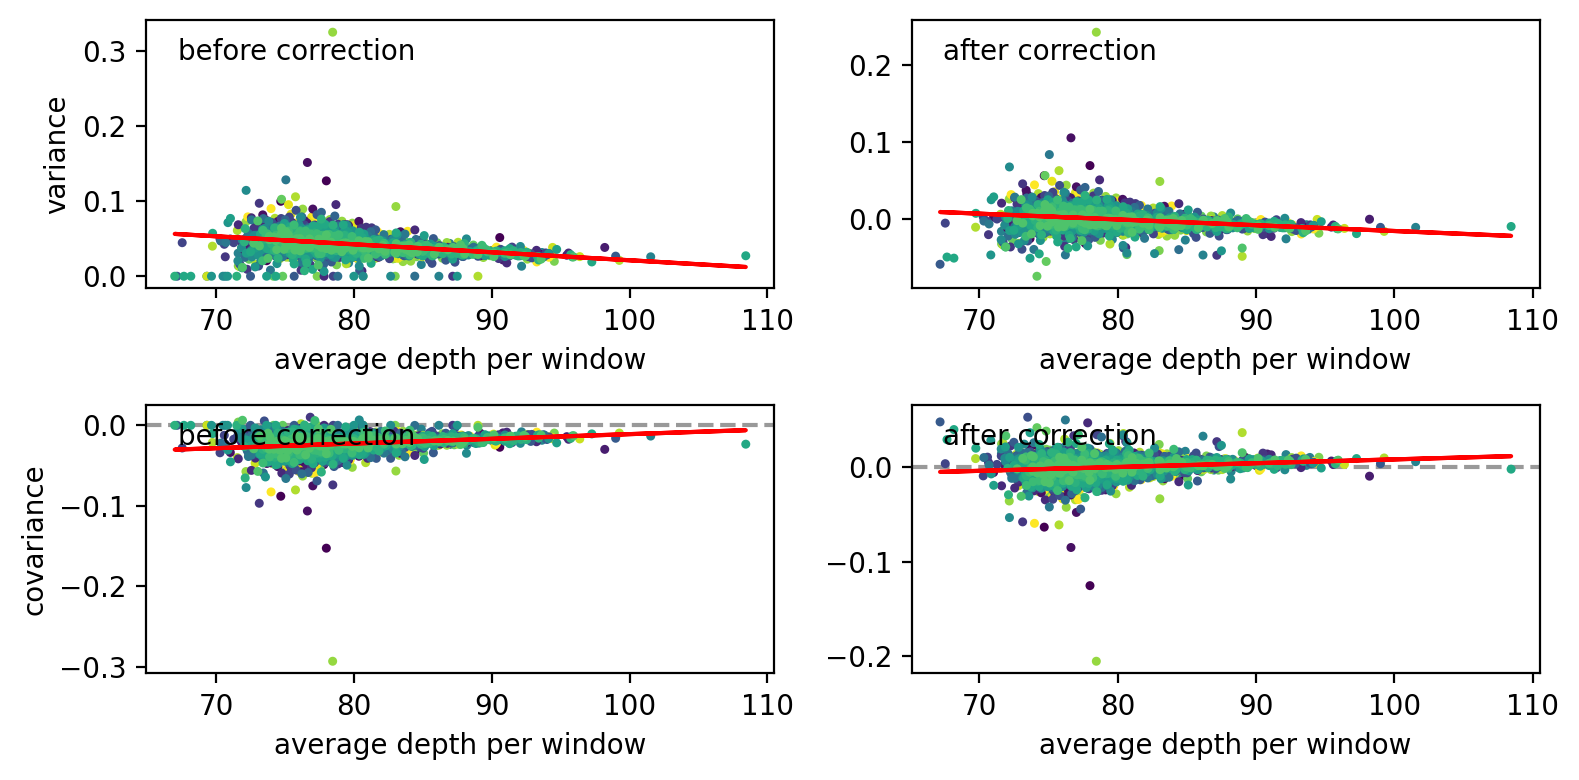

In [68]:
diagnostics = d.correction_diagnostics(use_masked=True)
_ = correction_diagnostic_plot(diagnostics)

## Variances  -not used for this dataset

In [65]:
# we need to keep track of number of years between
#m = re.compile(r'var\((?P<sample>[^:]+): (?P<start>\d+)-(?P<end>\d+)\)')
#converts = {'sample': str, 'start': int, 'end': int}
#var_labels = [[tuple(converts[k](m.match(s).groupdict()[k]) for k in 'sample start end'.split(' ')) 
#  for s in np.diag(stacked_temp_labs.T[i])] for i in range(stacked_temp_labs.T.shape[0])]


# manual fix: PWS 2006 is really 2007
var_labels = [[('PWS', 1996, 1991), ('PWS', 2007, 1996), ('PWS', 2017, 2007)],
              [('SS', 1996, 1991), ('SS', 2006, 1996), ('SS', 2017, 2006)],
              [('TB', 1996, 1991), ('TB', 2006, 1996), ('TB', 2017, 2006)]]


In [66]:
#Red lines = the mean from 1000 bootstrap results
#Blue lines = estiamted variance 

In [91]:
# here is the more precise procedure
B = 1000
window_covs = d.calc_cov_by_tile(use_masked=True)
straps = []

def var_estimator(freqs, depths, diploids):
    R, T, L = freqs.shape
    cov = temporal_replicate_cov(freqs, depths, diploids, use_masked=True)
    temp_covs = stack_temporal_covariances(cov, R, T-1).T
    vars = []
    for i in range(temp_covs.shape[0]):
        vars.append(np.diag(temp_covs[i, ...]))
    return np.stack(vars)
        

/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:375: RuntimeWarning: Mean of empty slice


In [92]:
var_straps = block_bootstrap(d.freqs, d.depths, d.diploids, d.tile_indices, d.tiles.seqid, B, var_estimator, return_straps=True, progress_bar=True)

bootstraps:   0%|          | 0/1000 [00:00<?, ?it/s]

In [72]:
var_straps.shape

(1000, 3, 3)

In [73]:
var_straps

array([[[-0.00233246, -0.00324593, -0.00134632],
        [        nan, -0.00046616, -0.00094138],
        [ 0.00080709,  0.00068968,  0.00071278]],

       [[-0.0024491 , -0.00334623, -0.00140721],
        [        nan, -0.00079287, -0.00116655],
        [ 0.00081469,  0.00036724,  0.000536  ]],

       [[-0.00240031, -0.0032262 , -0.0014773 ],
        [        nan, -0.00039661, -0.00081714],
        [ 0.00080234,  0.00071805,  0.00073953]],

       ...,

       [[-0.00244358, -0.00327116, -0.00153786],
        [        nan, -0.00090594, -0.00134457],
        [ 0.00077106,  0.00045369,  0.00064577]],

       [[-0.00235525, -0.00317313, -0.00148057],
        [        nan, -0.00043403, -0.00107067],
        [ 0.00089765,  0.00078107,  0.00071522]],

       [[-0.00245937, -0.00325435, -0.00149745],
        [        nan, -0.00047472, -0.00111043],
        [ 0.00085623,  0.00072192,  0.00069623]]])

### Estimate Ne from Var

#export the followings to create figures in R
var_labels
var_straps


In [74]:
pd.DataFrame(var_labels[0]).to_csv("MD7000_PWS_varlabels.csv",index_label=False)
pd.DataFrame(var_straps[:,0,:]).to_csv("MD7000_PWS_vars_bootstrap.csv",index_label=False)


In [75]:
pd.DataFrame(var_labels[1]).to_csv("MD7000_SS_varlabels.csv",index_label=False)
pd.DataFrame(var_straps[:,1,:]).to_csv("MD7000_SS_vars_bootstrap.csv",index_label=False)

pd.DataFrame(var_labels[2]).to_csv("MD7000_TB_varlabels.csv",index_label=False)
pd.DataFrame(var_straps[:,2,:]).to_csv("MD7000_TB_vars_bootstrap.csv",index_label=False)


In [78]:
pd.DataFrame(var_straps[:,0,:])

,0,1,2
0,-0.002332,-0.003246,-0.001346
1,-0.002449,-0.003346,-0.001407
2,-0.002400,-0.003226,-0.001477
3,-0.002359,-0.003141,-0.001485
4,-0.002350,-0.003078,-0.001368
...,...,...,...
995,-0.002418,-0.003114,-0.001238
996,-0.002142,-0.003113,-0.001092
997,-0.002444,-0.003271,-0.001538
998,-0.002355,-0.003173,-0.001481


/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/kahotisthammer/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


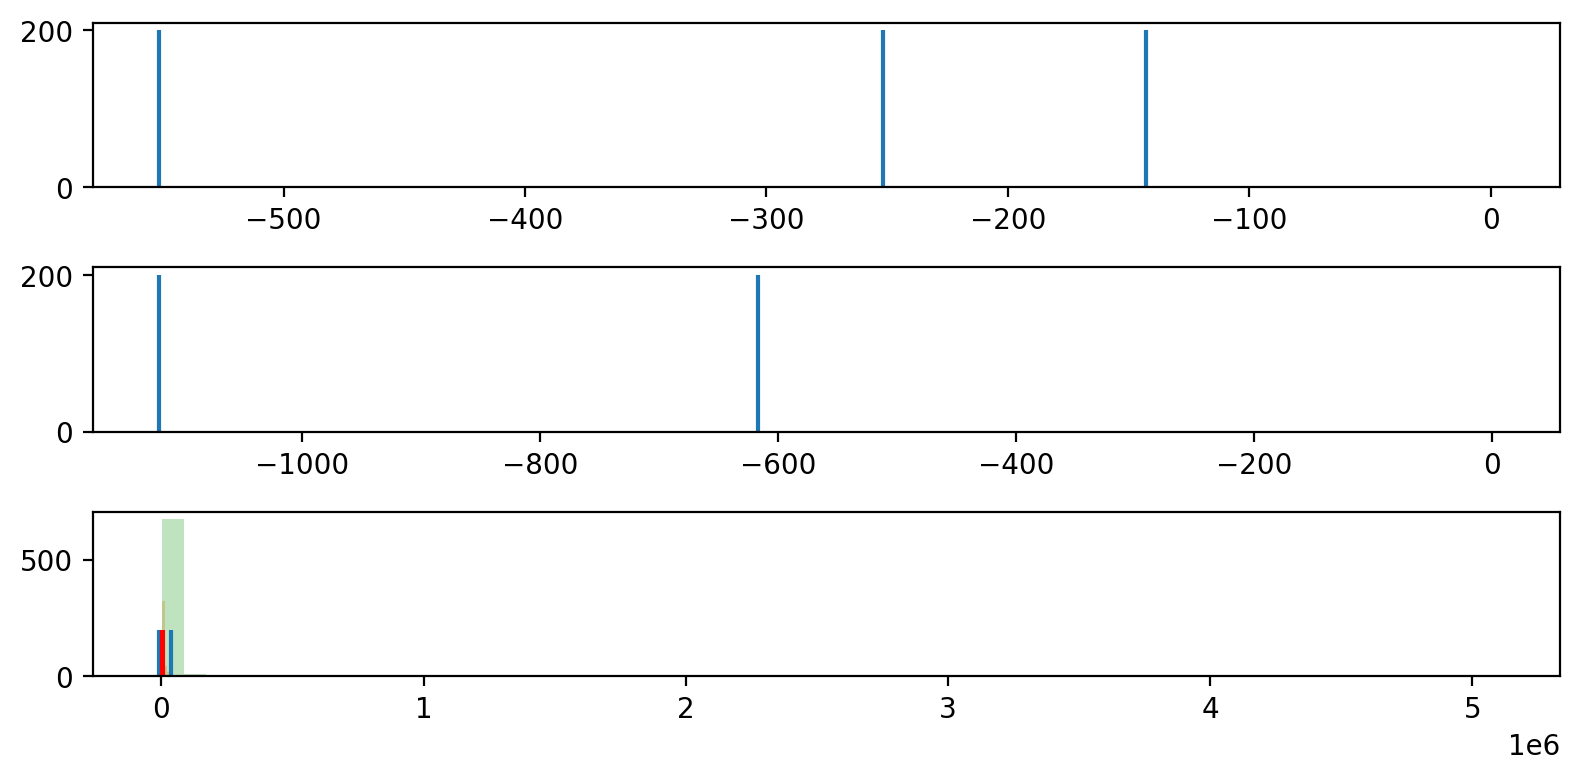

In [61]:
gen_time = 1/6

Ne_CIs = dict()

fig, ax = plt.subplots(ncols=1, nrows=3, sharex=False)
for i in range(3):
    years = []
    cis = []
    for j in range(3):
        sample, end, start = var_labels[i][j]
        nyears = end - start
        x = var_straps[:, i, j]
        x = x[np.isfinite(x)]
        x = x[x > 0]

        #ax[i].text(0.9, 0.8, sample, transform=ax[i].transAxes)
        ax[i].hist(nyears * gen_time * 0.5/x, 60, alpha=0.3)
        #if i == 0:
        #    ax[i].set_xlim(0, 2000)
        #ax[i].set_xlim(0, 10000)
        ax[i].vlines(nyears * gen_time * 0.5/np.mean(x), 0, 200, color='r')
        ax[i].vlines(nyears * gen_time * 0.5/np.diag(stack_temporal_covariances(gw_covs, d.R, d.T).T[i, ...])[j], 0, 200)
        
        Ne = nyears * gen_time * 0.5/np.diag(stack_temporal_covariances(gw_covs, d.R, d.T).T[i, ...])[j]
        Ne_straps = nyears * gen_time * 0.5/var_straps[:, i, j]
        years.append((end, start))
        cis.append(bootstrap_ci(Ne, Ne_straps, method='standard'))
    Ne_CIs[sample] = (years, cis)

plt.tight_layout()

In [79]:
#TB T1
var31=var_straps[:, 2, 2]
ne31=0.5*5/6/var31

(array([  3.,  18.,  54.,  79., 112., 134., 111., 115.,  90.,  57.,  47.,
         48.,  38.,  30.,  18.,  12.,   9.,   3.,   5.,   4.,   3.,   1.,
          4.,   0.,   0.,   0.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([ 338.74862539,  368.23556668,  397.72250797,  427.20944926,
         456.69639055,  486.18333184,  515.67027313,  545.15721442,
         574.64415571,  604.131097  ,  633.61803829,  663.10497958,
         692.59192087,  722.07886216,  751.56580345,  781.05274474,
         810.53968603,  840.02662732,  869.51356861,  899.0005099 ,
         928.48745119,  957.97439248,  987.46133377, 1016.94827505,
        1046.43521634, 1075.92215763, 1105.40909892, 1134.89604021,
        1164.3829815 , 1193.86992279, 1223.35686408, 1252.84380537,
        1282.33074666, 1311.81768795, 1341.304

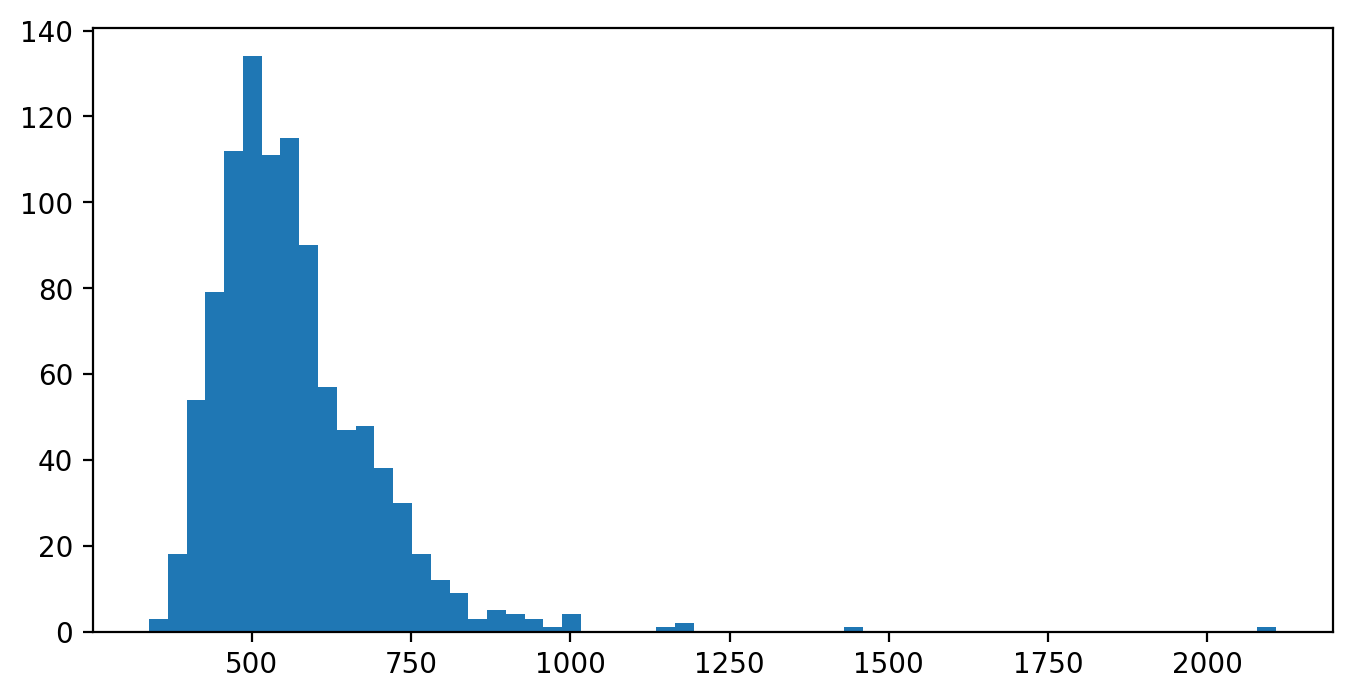

In [80]:
plt.hist(ne31, 60)

In [206]:
np.mean(ne31)

87.08067096862095

In [81]:
Ne_CIs #100k

{'PWS': ([(1996, 1991), (2007, 1996), (2017, 2007)],
  [array([-187.95193588, -172.22271949, -156.49350309]),
   array([-308.83103055, -286.46798902, -264.1049475 ]),
   array([-715.9882761 , -598.54395376, -481.09963142])]),
 'SS': ([(1996, 1991), (2006, 1996), (2017, 2006)],
  [array([nan, nan, nan]),
   array([-2417.65348061, -1488.8013548 ,  -559.94922898]),
   array([-1171.55030163,  -894.16899265,  -616.78768367])]),
 'TB': ([(1996, 1991), (2006, 1996), (2017, 2006)],
  [array([355.83661708, 475.73339271, 595.63016835]),
   array([ 605.70836964, 1272.09204859, 1938.47572754]),
   array([ 640.9660916 , 1193.27837588, 1745.59066017])])}

In [82]:
#export NI estiamtes
Ne_CIs_df = []
for sample, dats in Ne_CIs.items():
    time, cis = dats
    for i in range(3):
        Ne_CIs_df.append(dict(sample=sample, start=time[i][1], end=time[i][0], lower=cis[i][0], Ne=cis[i][1], upper=cis[i][2]))
    

In [83]:
pd.DataFrame(Ne_CIs_df).to_csv('MD7000_herring_Ne_estimates_100k.tsv',index=False)

[[-187.95193588 -172.22271949 -156.49350309]
 [-308.83103055 -286.46798902 -264.1049475 ]
 [-715.9882761  -598.54395376 -481.09963142]]
[[           nan            nan            nan]
 [-2417.65348061 -1488.8013548   -559.94922898]
 [-1171.55030163  -894.16899265  -616.78768367]]
[[ 355.83661708  475.73339271  595.63016835]
 [ 605.70836964 1272.09204859 1938.47572754]
 [ 640.9660916  1193.27837588 1745.59066017]]


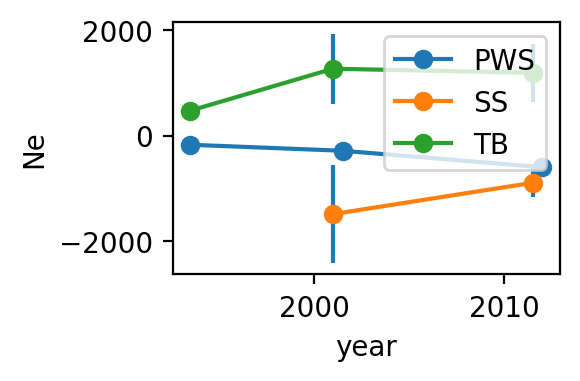

In [84]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3, 2), sharey=True)

labs = set()
for sample, (years, cis) in Ne_CIs.items():
    year_labels = [(end+start)/2 for end, start in years]
    cis = np.stack(cis)
    print(cis)
    lab = sample if sample not in labs else None
    labs.add(lab)
    ax.plot(year_labels, cis[:, 1], '-o', label=lab)
    ax.vlines(year_labels, cis[:, 0], cis[:, 2])
ax.set_ylabel("Ne")
ax.set_xlabel("year")
plt.legend()
plt.tight_layout()

[[ 207.43870953  587.97511241  968.51151529]
 [ 325.60574555 1054.20707393 1782.8084023 ]
 [ 232.85395072  270.19898575  307.54402078]]
[[         nan          nan          nan]
 [224.3884916  259.33554853 294.28260546]
 [233.28268915 275.94839272 318.61409629]]
[[ 90.64388492 101.0853305  111.52677609]
 [158.47916157 178.00648363 197.53380568]
 [170.90018458 190.46198248 210.02378038]]


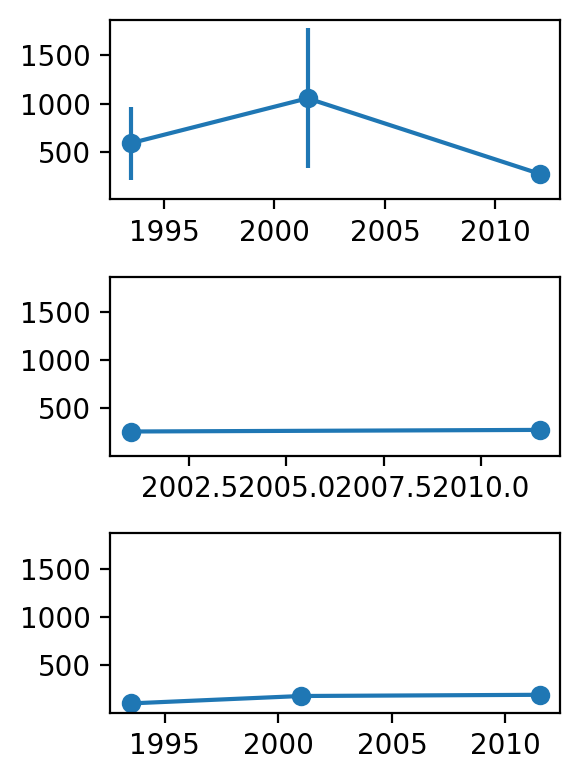

In [137]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(3, 4), sharey=True)

for i, (sample, (years, cis)) in enumerate(Ne_CIs.items()):
    year_labels = [(end+start)/2 for end, start in years]
    cis = np.stack(cis)
    print(cis)
    ax[i].plot(year_labels, cis[:, 1], '-o')
    ax[i].vlines(year_labels, cis[:, 0], cis[:, 2])
plt.tight_layout()

## Output the Covariance Matrices

In [51]:
#window size = 100k
WINSIZE = int(1e5)
{k: v/WINSIZE for k, v in seqlens.items()}

{'chr1': 330.84258,
 'chr2': 330.10319,
 'chr3': 325.27562,
 'chr4': 322.67647,
 'chr5': 315.86861,
 'chr6': 314.61554,
 'chr7': 309.90621,
 'chr8': 307.29556,
 'chr9': 304.77381,
 'chr10': 302.27731,
 'chr11': 300.96327,
 'chr12': 300.2248,
 'chr13': 298.45739,
 'chr14': 293.32771,
 'chr15': 287.13521,
 'chr16': 277.73822,
 'chr17': 275.6851,
 'chr18': 272.47294,
 'chr19': 271.30643,
 'chr20': 266.94162,
 'chr21': 264.65981,
 'chr22': 256.64052,
 'chr23': 252.92897,
 'chr24': 200.91098,
 'chr25': 149.24191,
 'chr26': 124.43209}

In [45]:
#window size = 50k
WINSIZE = 50000
{k: v/WINSIZE for k, v in seqlens.items()}

{'chr1': 661.68516,
 'chr2': 660.20638,
 'chr3': 650.55124,
 'chr4': 645.35294,
 'chr5': 631.73722,
 'chr6': 629.23108,
 'chr7': 619.81242,
 'chr8': 614.59112,
 'chr9': 609.54762,
 'chr10': 604.55462,
 'chr11': 601.92654,
 'chr12': 600.4496,
 'chr13': 596.91478,
 'chr14': 586.65542,
 'chr15': 574.27042,
 'chr16': 555.47644,
 'chr17': 551.3702,
 'chr18': 544.94588,
 'chr19': 542.61286,
 'chr20': 533.88324,
 'chr21': 529.31962,
 'chr22': 513.28104,
 'chr23': 505.85794,
 'chr24': 401.82196,
 'chr25': 298.48382,
 'chr26': 248.86418}

In [62]:
#window size = 50k
WINSIZE = 75000
{k: v/WINSIZE for k, v in seqlens.items()}

{'chr1': 441.12344,
 'chr2': 440.13758666666666,
 'chr3': 433.70082666666667,
 'chr4': 430.23529333333335,
 'chr5': 421.15814666666665,
 'chr6': 419.4873866666667,
 'chr7': 413.20828,
 'chr8': 409.72741333333335,
 'chr9': 406.36508,
 'chr10': 403.0364133333333,
 'chr11': 401.28436,
 'chr12': 400.29973333333334,
 'chr13': 397.9431866666667,
 'chr14': 391.1036133333333,
 'chr15': 382.84694666666667,
 'chr16': 370.3176266666667,
 'chr17': 367.5801333333333,
 'chr18': 363.29725333333334,
 'chr19': 361.7419066666667,
 'chr20': 355.92216,
 'chr21': 352.8797466666667,
 'chr22': 342.18736,
 'chr23': 337.2386266666667,
 'chr24': 267.88130666666666,
 'chr25': 198.98921333333334,
 'chr26': 165.90945333333335}

In [66]:
tiles

GenomicIntervals — 26 unique seqids, 9663 features
         GenomicInterval
0        chr1:[0, 75000)
1   chr1:[75000, 150000)
2  chr1:[150000, 225000)
3  chr1:[225000, 300000)
4  chr1:[300000, 375000)
[ 9658 more GenomicIntervals ]

In [63]:
#create the genomic interval object 
def binned_stat_windows(binned_stats, seqlens):
    gis = []
    for chrom, stats in binned_stats.items():
        for i in range(len(stats.bin_edges)-1):
            start, end = stats.bin_edges[i], stats.bin_edges[i+1]
            gis.append((chrom, start, end))
    return GenomicIntervals(gis, seqlens=seqlens)

#calculate covariance based on the window
def cov_windows(freqs, depths, diploids, gintervals, samples, tiles, seqlens=None):   
    d = TiledTemporalFreqs(tiles, freqs=freqs, depths=depths, diploids=diploids, gintervals=gintervals, samples=samples)
    covs = d.calc_cov_by_tile(use_masked=True)
    return covs, d
    

In [64]:
#This does not return the correct matrix
pws_tile_covs, d_ld = cov_windows(freqs=full_freq_mat, depths=full_depths_mat, diploids=new_ndiploids, gintervals=gi, samples=new_samples, tiles=tiles)

In [67]:
tile_covs_stacked = np.stack([stack_temporal_covariances(cov, d_ld.R, d_ld.T).T for cov in pws_tile_covs])

In [122]:
#pws_r2 = np.array(list(chain(*[c.statistic for c in pws_r2_bins.values()])))

In [68]:
tile_covs_stacked.shape

(9663, 3, 3, 3)

In [58]:
np.savetxt("PWS_cov12_1996-1991_2006-1996_md7000_100kwindow.csv", tile_covs_stacked[:,0,0,1], delimiter=",")
np.savetxt("PWS_cov13_2017-2006_1996-1991_md7000_100kwindow.csv", tile_covs_stacked[:,0,0,2], delimiter=",")
np.savetxt("PWS_cov23_2017-2006_2006-1996_md7000_100kwindow.csv", tile_covs_stacked[:,0,1,2], delimiter=",")

In [56]:
np.savetxt("SS_cov12_1996-1991_2006-1996_md7000_100kwindow.csv", tile_covs_stacked[:,1,0,1], delimiter=",")
np.savetxt("SS_cov13_2017-2006_1996-1991_md7000_100kwindow.csv", tile_covs_stacked[:,1,0,2], delimiter=",")
np.savetxt("SS_cov23_2017-2006_2006-1996_md7000_100kwindow.csv", tile_covs_stacked[:,1,1,2], delimiter=",")

In [57]:
np.savetxt("TB_cov12_1996-1991_2006-1996_md7000_100kwindow.csv", tile_covs_stacked[:,2,0,1], delimiter=",")
np.savetxt("TB_cov13_2017-2006_1996-1991_md7000_100kwindow.csv", tile_covs_stacked[:,2,0,2], delimiter=",")
np.savetxt("TB_cov23_2017-2006_2006-1996_md7000_100kwindow.csv", tile_covs_stacked[:,2,1,2], delimiter=",")

In [50]:
np.savetxt("PWS_cov12_1996-1991_2006-1996_md7000_50kwindow.csv", tile_covs_stacked[:,0,0,1], delimiter=",")
np.savetxt("PWS_cov13_2017-2006_1996-1991_md7000_50kwindow.csv", tile_covs_stacked[:,0,0,2], delimiter=",")
np.savetxt("PWS_cov23_2017-2006_2006-1996_md7000_50kwindow.csv", tile_covs_stacked[:,0,1,2], delimiter=",")

In [51]:
np.savetxt("SS_cov12_1996-1991_2006-1996_md7000_50kwindow.csv", tile_covs_stacked[:,1,0,1], delimiter=",")
np.savetxt("SS_cov13_2017-2006_1996-1991_md7000_50kwindow.csv", tile_covs_stacked[:,1,0,2], delimiter=",")
np.savetxt("SS_cov23_2017-2006_2006-1996_md7000_50kwindow.csv", tile_covs_stacked[:,1,1,2], delimiter=",")

In [52]:
np.savetxt("TB_cov12_1996-1991_2006-1996_md7000_50kwindow.csv", tile_covs_stacked[:,2,0,1], delimiter=",")
np.savetxt("TB_cov13_2017-2006_1996-1991_md7000_50kwindow.csv", tile_covs_stacked[:,2,0,2], delimiter=",")
np.savetxt("TB_cov23_2017-2006_2006-1996_md7000_50kwindow.csv", tile_covs_stacked[:,2,1,2], delimiter=",")

In [69]:
np.savetxt("PWS_cov12_1996-1991_2006-1996_md7000_75kwindow.csv", tile_covs_stacked[:,0,0,1], delimiter=",")
np.savetxt("PWS_cov13_2017-2006_1996-1991_md7000_75kwindow.csv", tile_covs_stacked[:,0,0,2], delimiter=",")
np.savetxt("PWS_cov23_2017-2006_2006-1996_md7000_75kwindow.csv", tile_covs_stacked[:,0,1,2], delimiter=",")

np.savetxt("SS_cov12_1996-1991_2006-1996_md7000_75kwindow.csv", tile_covs_stacked[:,1,0,1], delimiter=",")
np.savetxt("SS_cov13_2017-2006_1996-1991_md7000_75kwindow.csv", tile_covs_stacked[:,1,0,2], delimiter=",")
np.savetxt("SS_cov23_2017-2006_2006-1996_md7000_75kwindow.csv", tile_covs_stacked[:,1,1,2], delimiter=",")

np.savetxt("TB_cov12_1996-1991_2006-1996_md7000_75kwindow.csv", tile_covs_stacked[:,2,0,1], delimiter=",")
np.savetxt("TB_cov13_2017-2006_1996-1991_md7000_75kwindow.csv", tile_covs_stacked[:,2,0,2], delimiter=",")
np.savetxt("TB_cov23_2017-2006_2006-1996_md7000_75kwindow.csv", tile_covs_stacked[:,2,1,2], delimiter=",")

In [70]:
intervals=pd.DataFrame(tiles.data)

In [71]:
intervals["chrom"]=tiles.seqid
intervals["start"]=tiles.start
intervals["end"]=tiles.end

In [61]:
intervals.to_csv("MD7000_3pops_intervals_100kwindow.csv",index_label=False)

In [55]:
intervals.to_csv("MD7000_3pops_intervals_50kwindow.csv",index_label=False)

In [72]:
intervals.to_csv("MD7000_3pops_intervals_75kwindow.csv",index_label=False)

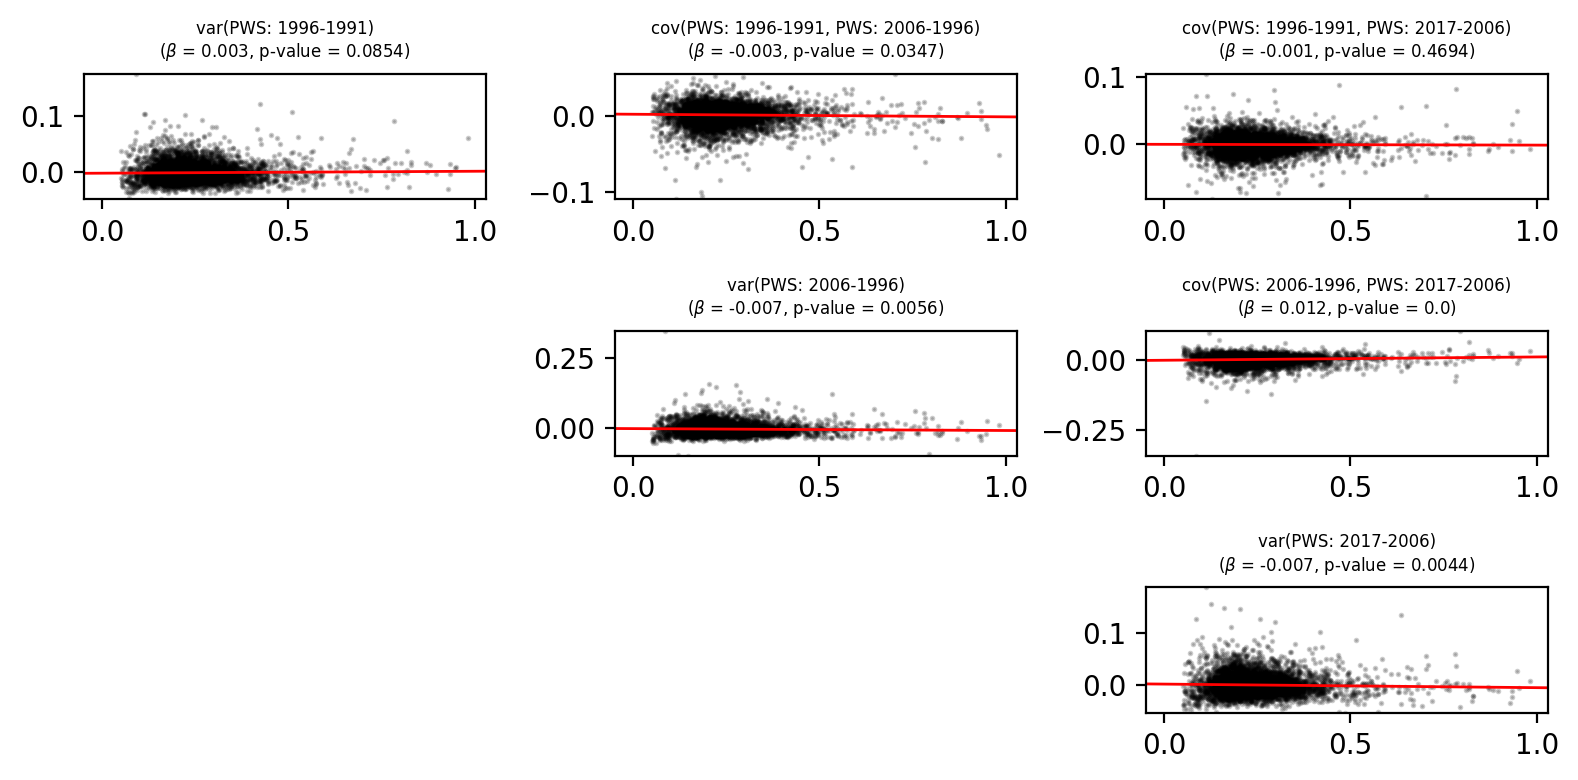

In [146]:
#PWS plots 100k window
cov_ld_plot(0, tile_covs_stacked, pws_r2, labs)

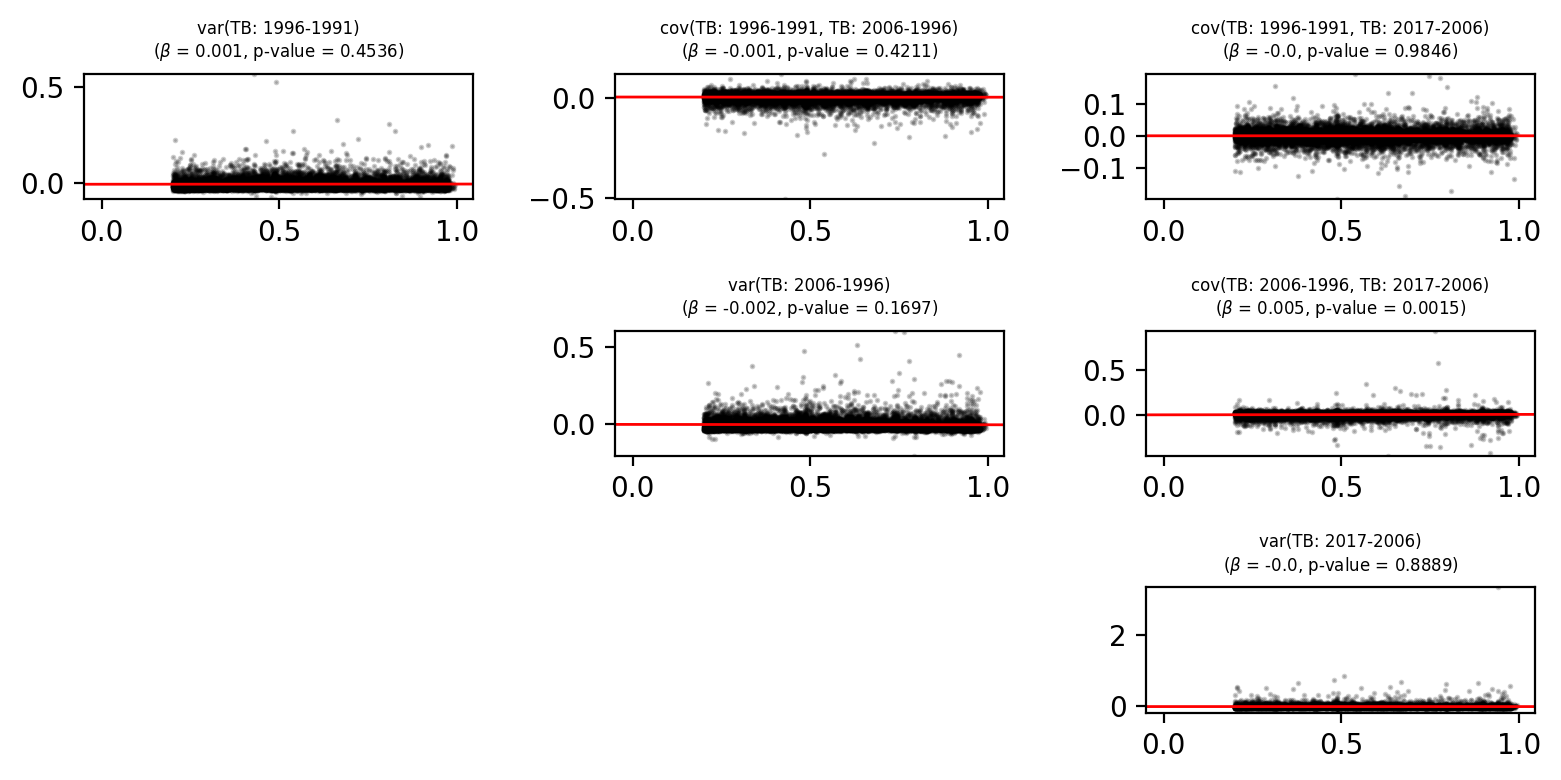

In [103]:
cov_ld_plot(2, tile_covs_stacked, tb_r2, labs)

In [245]:
np.savetxt("TB_var1_1996_1991.csv", tile_covs_stacked[:,2,0,0], delimiter=",")
np.savetxt("TB_cov12_1996-1991_2006-1996.csv", tile_covs_stacked[:,2,0,1], delimiter=",")
np.savetxt("TB_cov13_2017-2006_1996-1991.csv", tile_covs_stacked[:,2,0,2], delimiter=",")
np.savetxt("TB_var2_2006_1996.csv", tile_covs_stacked[:,2,1,1], delimiter=",")
np.savetxt("TB_cov23_2017-2006_2006-1996.csv", tile_covs_stacked[:,2,1,2], delimiter=",")
np.savetxt("TB_var3_2017_2006.csv", tile_covs_stacked[:,2,2,2], delimiter=",")

In [246]:
ss_r2_bins = plink_ld_bins(ss_ld, winsize=WINSIZE, seqlens=seqlens)
ss_r2_tiles = binned_stat_windows(ss_r2_bins, seqlens)
ss_r2 = np.array(list(chain(*[c.statistic for c in ss_r2_bins.values()])))

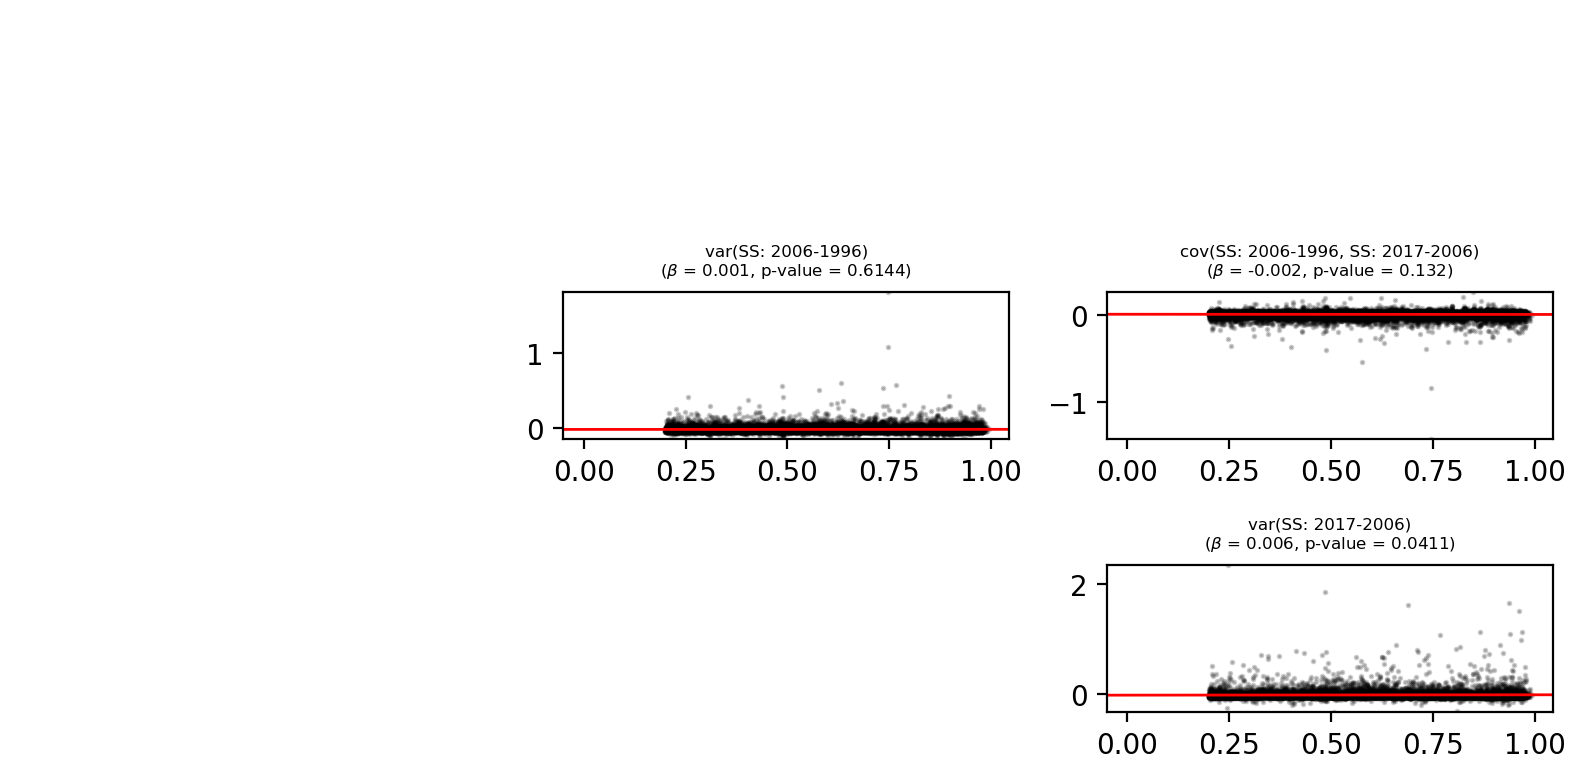

In [144]:
cov_ld_plot(1, tile_covs_stacked, ss_r2, labs, ignore=[(0, 0), (0, 1), (0, 2)])

In [247]:
np.savetxt("SS_var2_2006_1996.csv", tile_covs_stacked[:,1,1,1], delimiter=",")
np.savetxt("SS_cov23_2017-2006_2006-1996.csv", tile_covs_stacked[:,1,1,2], delimiter=",")
np.savetxt("SS_var3_2017_2006.csv", tile_covs_stacked[:,1,2,2], delimiter=",")

In [138]:
def convergence_corr(covs, R, T):
     replicate_covs = stack_replicate_covariances(covs, R, T, upper_only=False)
     temporal_covs = stack_temporal_covariances(covs, R, T)
     num, denom = (convergence_corr_numerator(replicate_covs[np.newaxis, ...]),
                   convergence_corr_denominator(temporal_covs[np.newaxis, ...]))
     return num / denom 

def convergence_corr_numerator(stacked_replicate_covs):
    """
    E_{A≠B} cov(Δp_{t,A}, Δp_{s,B})
    """
    assert(stacked_replicate_covs.ndim == 4)
    #return stacked_replicate_covs
    return np.mean(stacked_replicate_covs, axis=3)

def convergence_corr_denominator(stacked_temporal_covs):
    """
    E_{A≠B} sqrt(var(Δp_{t,A}) var(Δp_{s,B}))
    """
    assert(stacked_temporal_covs.ndim == 4)
    nblocks, T, T_, R = stacked_temporal_covs.shape
    vars = np.diagonal(stacked_temporal_covs, offset=0, axis1=1, axis2=2)
    # get the outer products over time and replicates
    varmat = np.einsum('bri,bqj->brqij', vars, vars)
    # the following gets all A, B replicate pairs where A ≠ B
    tr, tc = np.triu_indices(R, k=1)
    sdmat = np.sqrt(varmat[:, tr, tc, :, :].mean(axis=1))
    return sdmat
    

In [139]:
convergence_corr(gw_covs, d.R, d.T)

array([[[        nan,         nan,         nan],
        [        nan,  0.00559169,  0.05377123],
        [        nan,  0.04041366, -0.05121257]]])

In [158]:
stack_replicate_covariances(gw_covs, 3, 3, upper_only=False).T

array([[[            nan,             nan,             nan],
        [            nan, -2.51359887e-04,  2.03023103e-04],
        [            nan,  1.05470660e-03, -1.01999609e-03]],

       [[-6.12183755e-04, -1.50021950e-04, -2.82529923e-04],
        [-2.62163452e-04, -1.30682430e-04, -6.25890374e-05],
        [ 6.99702299e-04,  4.74194260e-04,  2.73271000e-04]],

       [[            nan,             nan,             nan],
        [            nan, -2.51359887e-04,  1.05470660e-03],
        [            nan,  2.03023103e-04, -1.01999609e-03]],

       [[            nan,             nan,             nan],
        [            nan,  4.27374335e-04, -2.38270566e-04],
        [            nan, -5.46752048e-04,  1.78220923e-04]],

       [[-6.12183755e-04, -2.62163452e-04,  6.99702299e-04],
        [-1.50021950e-04, -1.30682430e-04,  4.74194260e-04],
        [-2.82529923e-04, -6.25890374e-05,  2.73271000e-04]],

       [[            nan,             nan,             nan],
        [     

### create null distribution of covariances

In [159]:
def calc_deltas(freqs):
    """
    Calculates the deltas matrix, which is the frequency matrix where
    entry out[n] = x[n+1] - x[n]. This takes a R x T x L frequency array.
    """
    if freqs.ndim == 2:
        return np.diff(freqs, axis=0)
    elif freqs.ndim == 3:
        return np.diff(freqs, axis=1)
    else:
        raise ValueError("eqs.ndim must be eitehr 2 or 3")


In [171]:
def sign_permute_delta_matrix(deltas, blocks=None):
    """
    Permute and flip the sign of the timepoints in the
    R x T x L deltas matrix.
    """
    assert(deltas.ndim == 3)
    R, T, L = deltas.shape
    resampled_deltas = np.array(deltas)  # copy
    if blocks is None:
        flips = np.tile(np.random.choice((-1, 1), size=(T, 1)), L)
    else:
        nblocks = len(set(blocks))
        # TODO make a flip per block
        #assert(sorted(blocks) == blocks)
        block_reps = [len(list(x)) for group, x in groupby(blocks)]
        flips = np.repeat(np.random.choice((-1, 1), size=(nblocks, T)), block_reps, axis=0)
    resampled_deltas *= flips.T
    return resampled_deltas

In [83]:
CACHED_EMPCOV_TILE = f'empnull_tile_100k.npy'


In [ ]:
empcov_tile = d.calc_empirical_null(B=100, by_tile=True, sign_permute_blocks='tile',
                                        bias_correction=False, progress_bar=True)

In [85]:
empcov_tile

array([[[[[ 1.67342630e-02,             nan,  3.36588239e-02],
          [-2.66202883e-02,             nan, -4.51352368e-02],
          [-2.96717211e-02,             nan, -3.04149543e-02]],

         [[-2.66202883e-02,             nan, -4.51352368e-02],
          [ 8.20144100e-02,  4.32130390e-02,  7.77966591e-02],
          [ 6.63940779e-02,  4.36920543e-02,  4.41788767e-02]],

         [[-2.96717211e-02,             nan, -3.04149543e-02],
          [ 6.63940779e-02,  4.36920543e-02,  4.41788767e-02],
          [ 8.32586335e-02,  8.50614075e-02,  5.98768009e-02]]],


        [[[ 5.75312622e-02,             nan,  3.42457577e-02],
          [ 1.20883035e-02,             nan, -2.14798746e-02],
          [-3.40527245e-02,             nan,  3.83529430e-03]],

         [[ 1.20883035e-02,             nan, -2.14798746e-02],
          [ 4.61929737e-02,  4.40583521e-02,  3.86605960e-02],
          [-4.26633797e-02, -1.21897127e-02, -2.33408564e-02]],

         [[-3.40527245e-02,             nan

In [84]:
with open(CACHED_EMPCOV_TILE, 'rb') as f:
        empcov_tile = np.load(f)

  0%|          | 0/100 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'empnull_tile_100k.npy'

In [169]:
deltas=calc_deltas(d.freqs)

In [173]:
nulls=sign_permute_delta_matrix(deltas)

ValueError: operands could not be broadcast together with shapes (3,3,204153) (204153,3) (3,3,204153) 

In [174]:
delteas=calc_deltas(full_freq_mat)

In [175]:
nulls=sign_permute_delta_matrix(deltas)

ValueError: operands could not be broadcast together with shapes (3,3,204153) (204153,3) (3,3,204153) 

## Bootstrapping CIs

In [71]:
gw_covs_cis = d.bootstrap_cov(B=5000, progress_bar=True, use_masked=True, average_replicates=False)

/home/vsb/projects/cvtkpy/cvtk/cov.py:309: RuntimeWarning: Mean of empty slice
  mean_hets = np.nanmean(hets, axis=freqs.ndim-1)
/home/vsb/projects/cvtkpy/cvtk/cov.py:370: RuntimeWarning: invalid value encountered in multiply
  ave_bias += np.nanmean(0.5 * hets * (diploid_correction + depth_correction), axis=2)
/home/vsb/projects/cvtkpy/cvtk/cov.py:370: RuntimeWarning: Mean of empty slice
  ave_bias += np.nanmean(0.5 * hets * (diploid_correction + depth_correction), axis=2)


/home/vsb/miniconda3/envs/cvtk/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/vsb/projects/cvtkpy/cvtk/bootstrap.py:22: RuntimeWarning: invalid value encountered in subtract
  CIs = 2*estimate - qupper, estimate, 2*estimate - qlower


In [72]:
[stack_replicate_covariances(gw_covs_cis[i, ...], d.R, d.T, stack=True)[:, 0, 1] for i in range(3)]

[array([        nan, -0.00072806,         nan]),
 array([        nan, -0.00048104,         nan]),
 array([        nan, -0.00022405,         nan])]

In [73]:
# get just the off-diag covs
T = d.T

def extract_varcov_values(covmat, type='temporal'):
    rep_cis, temp_cis, rep_labels, temp_labels = {}, {}, {}, {}
    mode = (False, True) # only covs
    if type == 'replicate':
        mode = (True, True)
    if type == 'variance':
        mode = (True, False)
    u1, u2 = {(True, True): np.triu_indices(T, k=0), 
              (True, False): np.diag_indices(T), 
              (False, True): np.triu_indices(T, k=1)}[mode]
    flat = lambda x: x.flatten().squeeze()
    for i, label in zip((0, 1, 2), ('lower', 'mean', 'upper')):
        tmp = stack_temporal_covariances(covmat[i, ...], d.R, d.T, return_labels=True, samples=d.samples, stack=True)
        temp_cis[label], temp_labels = flat(tmp[0][:, u1, u2]), flat(tmp[1][:, u1, u2])
        tmp = stack_replicate_covariances(covmat[i, ...], d.R, d.T, return_labels=True, samples=d.samples, stack=True)    
        rep_cis[label], rep_labels  = flat(tmp[0][:, u1, u2]), flat(tmp[1][:, u1, u2])
    if type == 'replicate':
        return rep_cis, rep_labels
    if type in ('temporal', 'variance'):
        return temp_cis,temp_labels
    return None

rep_cis, rep_labels = extract_varcov_values(gw_covs_cis, type='replicate')
temp_cis, temp_labels = extract_varcov_values(gw_covs_cis, type='temporal')
var_cis, var_labels = extract_varcov_values(gw_covs_cis, type='variance')

In [469]:
rep_cis, rep_labels

({'lower': array([-3.83425174e-04,  1.18586801e-03, -1.15058013e-03, -1.38592637e-04,
          1.37247077e-04,  7.99511396e-05,  1.55901211e-04, -4.70049086e-04,
         -1.18611097e-05]),
  'mean': array([-2.40516244e-04,  1.40419607e-03, -9.27908721e-04,  2.02499335e-05,
          2.64424900e-04,  2.05248829e-04,  2.68705270e-04, -3.19026558e-04,
          1.02892476e-04]),
  'upper': array([-8.31713505e-06,  1.58886065e-03, -7.37977197e-04,  1.43089825e-04,
          4.33718731e-04,  3.36507741e-04,  4.07257219e-04, -1.93167918e-04,
          2.50759275e-04])},
 array(['rep_cov(SS: 2006-1996, PWS: 2006-1996)',
        'rep_cov(SS: 2006-1996, PWS: 2017-2006)',
        'rep_cov(SS: 2017-2006, PWS: 2017-2006)',
        'rep_cov(TB: 2006-1996, PWS: 2006-1996)',
        'rep_cov(TB: 2006-1996, PWS: 2017-2006)',
        'rep_cov(TB: 2017-2006, PWS: 2017-2006)',
        'rep_cov(TB: 2006-1996, SS: 2006-1996)',
        'rep_cov(TB: 2006-1996, SS: 2017-2006)',
        'rep_cov(TB: 2017-200

In [470]:
temp_cis

{'lower': array([-0.00361227, -0.00740486,  0.00286524]),
 'mean': array([-0.00331832, -0.00693156,  0.00290814]),
 'upper': array([-0.00302333, -0.00679221,  0.003464  ])}

In [477]:
temp_cis

{'lower': array([-0.00361227, -0.00740486,  0.00286524]),
 'mean': array([-0.00331832, -0.00693156,  0.00290814]),
 'upper': array([-0.00302333, -0.00679221,  0.003464  ])}

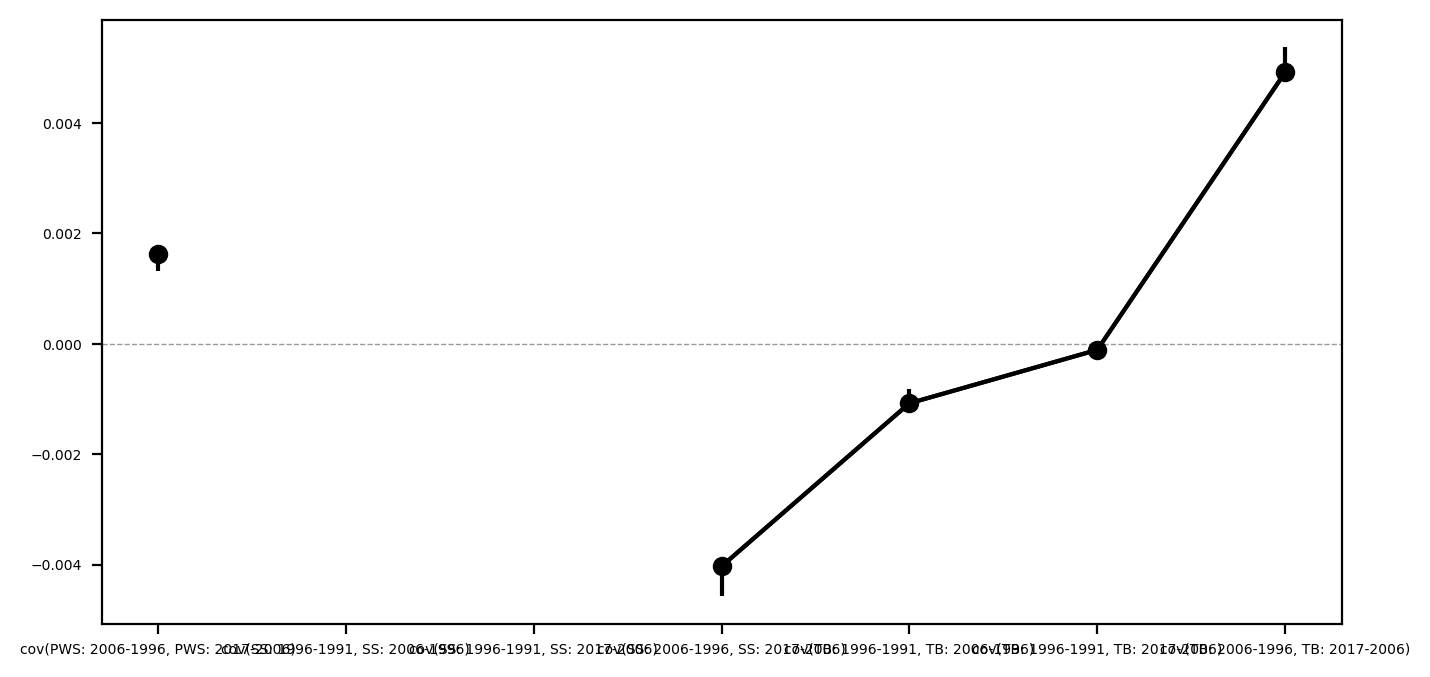

In [74]:
def CI_plot(x, means, lower=None, upper=None, hline=True, rotate_ticks=False, fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    ax.plot(x, means, '-o', c='k')
    l, u = means-lower, upper-means
    bars = np.row_stack([l, u])
    ax.errorbar(x, y=means, yerr=bars, c='k')
    if hline:
        ax.axhline(y=0, c='0.6', linewidth=0.5, zorder=-100, linestyle='--')
    if rotate_ticks:
        ax.tick_params(labelrotation=90)
    ax.tick_params(labelsize=5)
    
CI_plot(temp_labels, temp_cis['mean'], temp_cis['lower'], temp_cis['upper'])

In [472]:
rep_labels

array(['rep_cov(SS: 2006-1996, PWS: 2006-1996)',
       'rep_cov(SS: 2006-1996, PWS: 2017-2006)',
       'rep_cov(SS: 2017-2006, PWS: 2017-2006)',
       'rep_cov(TB: 2006-1996, PWS: 2006-1996)',
       'rep_cov(TB: 2006-1996, PWS: 2017-2006)',
       'rep_cov(TB: 2017-2006, PWS: 2017-2006)',
       'rep_cov(TB: 2006-1996, SS: 2006-1996)',
       'rep_cov(TB: 2006-1996, SS: 2017-2006)',
       'rep_cov(TB: 2017-2006, SS: 2017-2006)'], dtype='<U38')

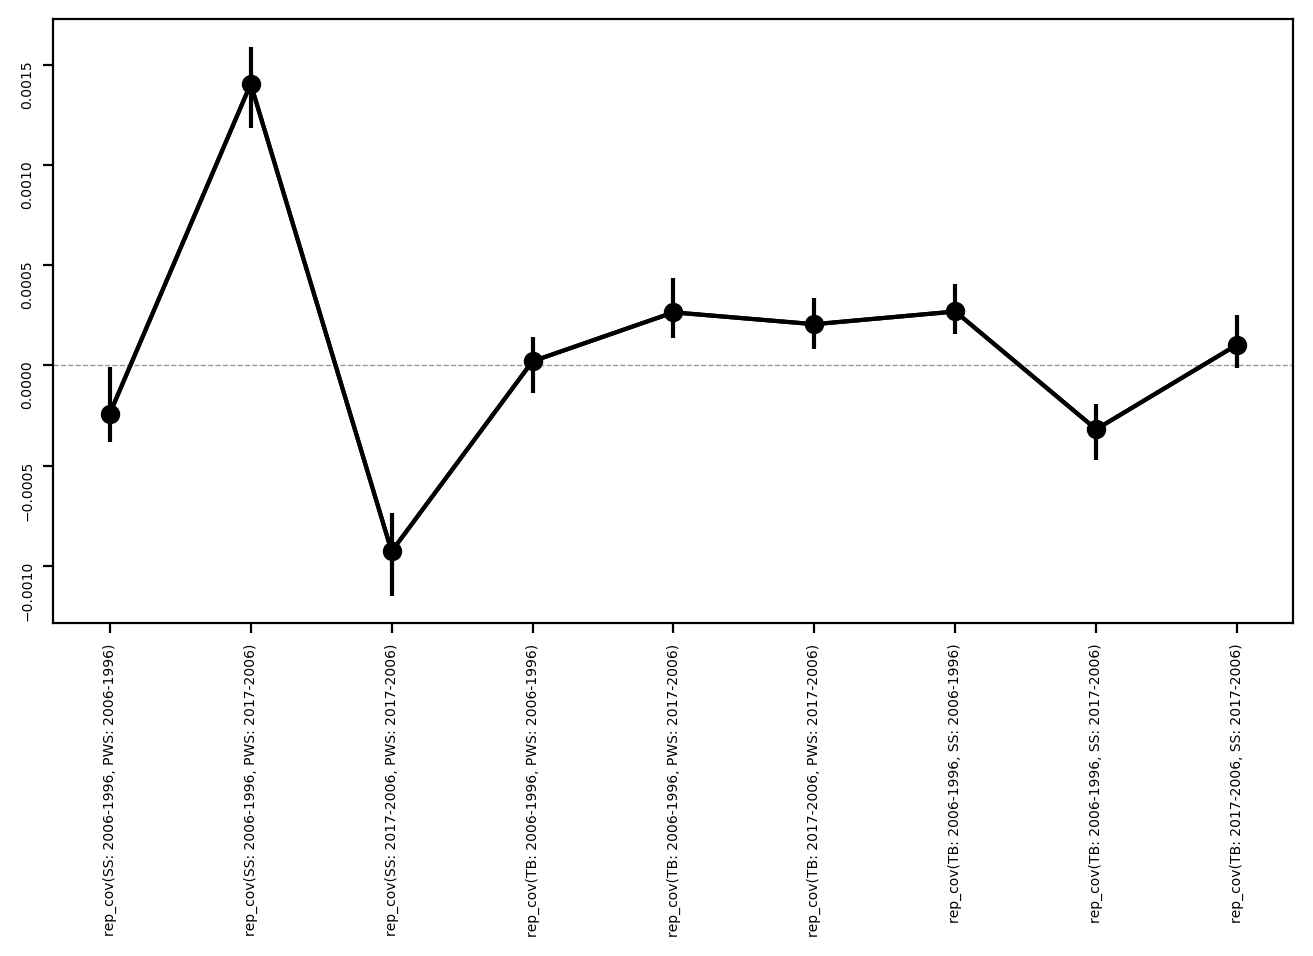

In [473]:
CI_plot(rep_labels, rep_cis['mean'], rep_cis['lower'], rep_cis['upper'], rotate_ticks=True)

In [83]:
var_labels

array(['var(PWS: 1996-1991)', 'var(PWS: 2006-1996)',
       'var(PWS: 2017-2006)', 'var(SS: 1996-1991)', 'var(SS: 2006-1996)',
       'var(SS: 2017-2006)', 'var(TB: 1996-1991)', 'var(TB: 2006-1996)',
       'var(TB: 2017-2006)'], dtype='<U38')

In [76]:
var_cis

{'lower': array([       nan, 0.00082886, 0.0057463 ,        nan, 0.00648431,
        0.00456618, 0.00103873, 0.00016825, 0.00068753]),
 'mean': array([       nan, 0.00125533, 0.00609152,        nan, 0.00671715,
        0.0047678 , 0.0014331 , 0.00080979, 0.00117721]),
 'upper': array([       nan, 0.0013659 , 0.00635597,        nan, 0.00706128,
        0.00519001, 0.00145904, 0.00076949, 0.00120286])}

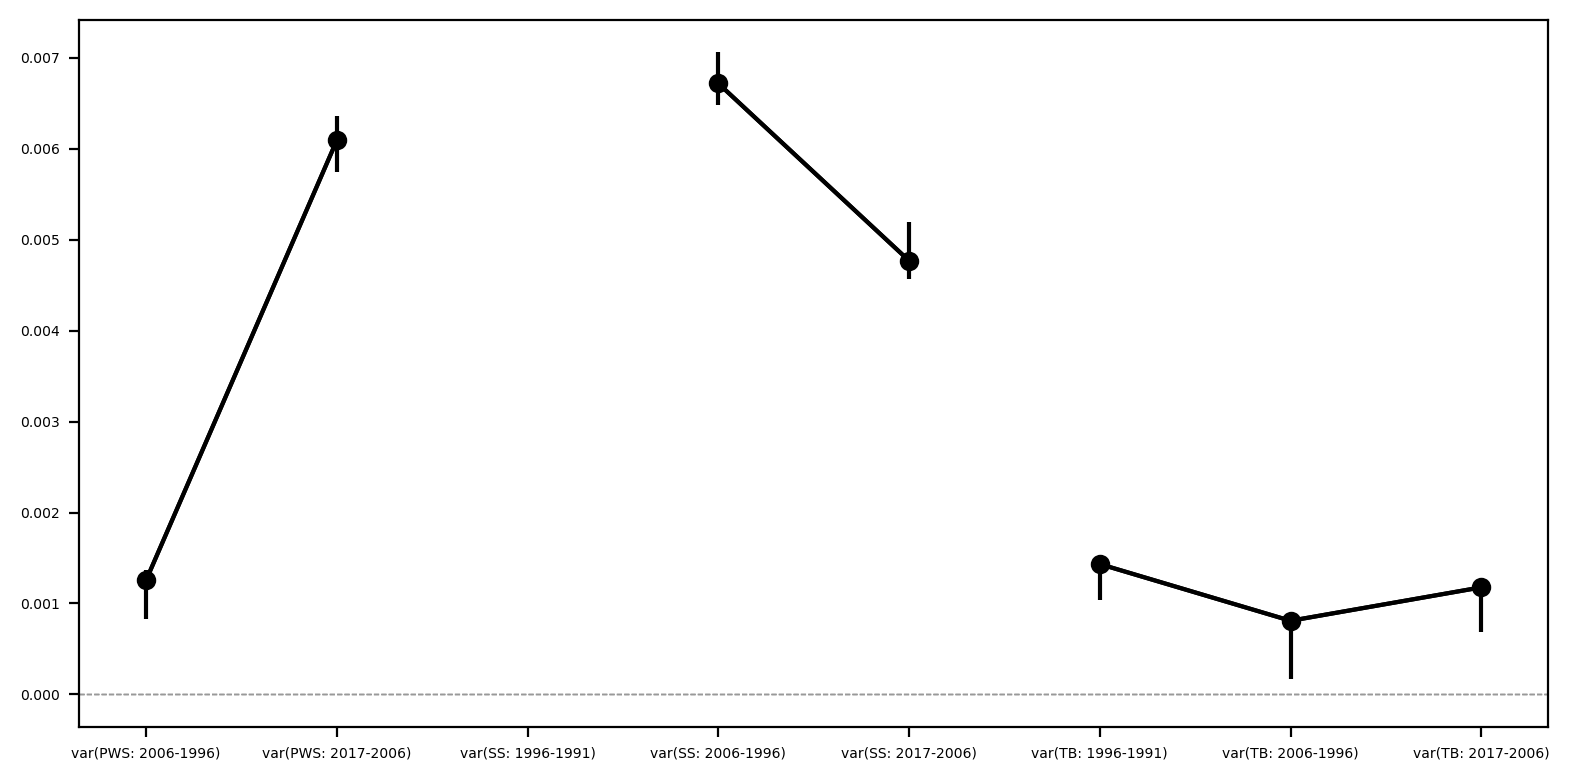

In [84]:
fig, ax = plt.subplots(ncols=1, nrows=1)

for i, row in enumerate(np.arange(var_labels.shape[0]).reshape((-1, 3))):
    idx = slice(row[0], row[2]+1)
    CI_plot(var_labels[idx], var_cis['mean'][idx], var_cis['lower'][idx], var_cis['upper'][idx], rotate_ticks=False, fig=fig, ax=ax)
plt.tight_layout()

In [476]:
def percent_change(old, new):
    return (new-old)/old

for x in stack_temporal_covariances(gw_covs_cis[1], d.R, d.T, stack=False):
    print(np.round(100 * percent_change(1/x[0, 0], 1/x[1, 1]),1))

-55.9
-4.0
-16.8


In [87]:
for x in stack_temporal_covariances(gw_covs_cis[1], d.R, d.T, stack=False):
    print(x)

[[ 0.00461835 -0.00331827]
 [-0.00331827  0.01047381]]
[[ 0.0085925  -0.00693157]
 [-0.00693157  0.00895134]]
[[0.00169163 0.00290818]
 [0.00290818 0.00203324]]


In [85]:
(1/0.00213072-1/0.00171745)/(1/.00171745)


-0.1939579109409026

In [76]:
d.samples

[('PWS', 1996),
 ('PWS', 2006),
 ('PWS', 2017),
 ('SS', 1996),
 ('SS', 2006),
 ('SS', 2017),
 ('TB', 1996),
 ('TB', 2006),
 ('TB', 2017)]

In [65]:
replicate_block_matrix_indices(d.R, d.T)

(array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2]]), array([[0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2],
        [0, 0, 1, 1, 2, 2]]))

In [67]:
d.T

2

In [68]:
d.R

3